In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
import xgboost
from xgboost import XGBRegressor, XGBClassifier

In [22]:
#####################################
# IMPORT AUXILIARY/CUSTOM FUNCTIONS #
#####################################

from AUX_MLL_BL import max_num_bins, Z_BL_asimov, BL_test_fast, BL_test_fsolve, MLL_test_fast, MLL_test_fsolve


# AUX FUNCTION TO FIND SOLUTIONS

def dx(fn, x, delta=0.001):
    return (fn(x+delta) - fn(x))/delta

def solvecross(fn, value, x=-45.5, maxtries=1000, maxerr=0.00001):
    for tries in range(maxtries):
        err = fn(x) - value
        if abs(err) < maxerr:
            return x
        slope = dx(fn, x)
        x -= err/slope
    raise ValueError('no solution found')

### DATA
pbot  --->  sum(bottom photomultipliers)

ptop  --->  sum(top photomultipliers)


ppeakS1 --> variables of S1 peak

ppeakS2 --> variables of S2 peak
    
        variables: pT0    -> absolute initial time of the pulse
                    pA    -> total integrated area of the pulse
                    pH    -> pulse maximum amplitude
                    pHT   -> time at which the pulse has max amplitude (from pT0)
                    pL    -> time length of the pulse
                    pL90  -> time length with 90% area of the pulse (from 5-95% integrated area)
                    pRMSW -> pulse root mean square (RMS) width
                    pHTL  -> ratio between pHT and pL

In [23]:
mDM = 500

filefolder = '../../data2024/processed/'

In [24]:
##############
# PARAMETERS #
##############

tot_B = 634.55+2.26+0.01+0.6+5.34

f_ER = 634.55 / tot_B
f_AC = 2.26 / tot_B
f_CNNS = 0.01 / tot_B
f_RN = 0.6 / tot_B
f_WALL = 5.34 / tot_B

f_ER + f_AC + f_CNNS + f_RN + f_WALL

S_cross1045 = 33.24

cross_factor = np.logspace(-47,-44,10) / 1e-45
S_expected = [max(1, round(S_cross1045 * fac)) for fac in cross_factor]


# DISCOVERY: 'discovery', EXCLUSION: 'exclusion'
D_or_E = 'exclusion'

# requested number of pseudo experiments
num_pseudo = 2000

# number of expected background events per ensemble
B_expected = round(tot_B)

print('B_expected: ', B_expected)
print('S_cross1045: ', S_cross1045)
print('S_expected (from cross=1e-47 to 1e-44): ', S_expected)

B_expected:  643
S_cross1045:  33.24
S_expected (from cross=1e-47 to 1e-44):  [1, 1, 2, 3, 7, 15, 33, 72, 154, 332]


In [25]:
###############
# BACKGROUNDS # 
###############

B_pbot_ER = np.loadtxt(filefolder + 'ER/pbot.txt')
B_ptop_ER = np.loadtxt(filefolder + 'ER/ptop.txt')
B_ppeakS1_ER = np.loadtxt(filefolder + 'ER/ppeakS1.txt')
B_ppeakS2_ER = np.loadtxt(filefolder + 'ER/ppeakS2.txt')

print('B_pbot_ER.shape: ', B_pbot_ER.shape)
print('B_ptop_ER.shape: ', B_ptop_ER.shape)
print('B_ppeakS1_ER.shape :', B_ppeakS1_ER.shape)
print('B_ppeakS2_ER.shape: ', B_ppeakS2_ER.shape)


B_pbot_AC = np.loadtxt(filefolder + 'AC/pbot.txt')
B_ptop_AC = np.loadtxt(filefolder + 'AC/ptop.txt')
B_ppeakS1_AC = np.loadtxt(filefolder + 'AC/ppeakS1.txt')
B_ppeakS2_AC = np.loadtxt(filefolder + 'AC/ppeakS2.txt')

print('\nB_pbot_AC.shape: ', B_pbot_AC.shape)
print('B_ptop_AC.shape: ', B_ptop_AC.shape)
print('B_ppeakS1_AC.shape :', B_ppeakS1_AC.shape)
print('B_ppeakS2_AC.shape: ', B_ppeakS2_AC.shape)


B_pbot_CNNS = np.loadtxt(filefolder + 'CNNS/pbot.txt')
B_ptop_CNNS = np.loadtxt(filefolder + 'CNNS/ptop.txt')
B_ppeakS1_CNNS = np.loadtxt(filefolder + 'CNNS/ppeakS1.txt')
B_ppeakS2_CNNS = np.loadtxt(filefolder + 'CNNS/ppeakS2.txt')

print('\nB_pbot_CNNS.shape: ', B_pbot_CNNS.shape)
print('B_ptop_CNNS.shape: ', B_ptop_CNNS.shape)
print('B_ppeakS1_CNNS.shape :', B_ppeakS1_CNNS.shape)
print('B_ppeakS2_CNNS.shape: ', B_ppeakS2_CNNS.shape)


B_pbot_RN = np.loadtxt(filefolder + 'RN/pbot.txt')
B_ptop_RN = np.loadtxt(filefolder + 'RN/ptop.txt')
B_ppeakS1_RN = np.loadtxt(filefolder + 'RN/ppeakS1.txt')
B_ppeakS2_RN = np.loadtxt(filefolder + 'RN/ppeakS2.txt')

print('\nB_pbot_RN.shape: ', B_pbot_RN.shape)
print('B_ptop_RN.shape: ', B_ptop_RN.shape)
print('B_ppeakS1_RN.shape :', B_ppeakS1_RN.shape)
print('B_ppeakS2_RN.shape: ', B_ppeakS2_RN.shape)


B_pbot_WALL = np.loadtxt(filefolder + 'WALL/pbot.txt')
B_ptop_WALL = np.loadtxt(filefolder + 'WALL/ptop.txt')
B_ppeakS1_WALL = np.loadtxt(filefolder + 'WALL/ppeakS1.txt')
B_ppeakS2_WALL = np.loadtxt(filefolder + 'WALL/ppeakS2.txt')

print('\nB_pbot_WALL.shape: ', B_pbot_WALL.shape)
print('B_ptop_WALL.shape: ', B_ptop_WALL.shape)
print('B_ppeakS1_WALL.shape :', B_ppeakS1_WALL.shape)
print('B_ppeakS2_WALL.shape: ', B_ppeakS2_WALL.shape)


##########
# SIGNAL #
##########

S_pbot = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/pbot.txt')
S_ptop = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ptop.txt')
S_ppeakS1 = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ppeakS1.txt')
S_ppeakS2 = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ppeakS2.txt')

print('\nS_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

B_pbot_ER.shape:  (35549,)
B_ptop_ER.shape:  (35549,)
B_ppeakS1_ER.shape : (35549, 8)
B_ppeakS2_ER.shape:  (35549, 8)

B_pbot_AC.shape:  (3998,)
B_ptop_AC.shape:  (3998,)
B_ppeakS1_AC.shape : (3998, 8)
B_ppeakS2_AC.shape:  (3998, 8)

B_pbot_CNNS.shape:  (99,)
B_ptop_CNNS.shape:  (99,)
B_ppeakS1_CNNS.shape : (99, 8)
B_ppeakS2_CNNS.shape:  (99, 8)

B_pbot_RN.shape:  (2610,)
B_ptop_RN.shape:  (2610,)
B_ppeakS1_RN.shape : (2610, 8)
B_ppeakS2_RN.shape:  (2610, 8)

B_pbot_WALL.shape:  (4642,)
B_ptop_WALL.shape:  (4642,)
B_ppeakS1_WALL.shape : (4642, 8)
B_ppeakS2_WALL.shape:  (4642, 8)

S_pbot.shape:  (32015,)
S_ptop.shape:  (32015,)
S_ppeakS1.shape : (32015, 8)
S_ppeakS2.shape:  (32015, 8)


##### Select the number of events per class

In [26]:
NUM_DAT = min(len(B_pbot_ER), len(S_pbot))
print(' NUM_DAT: ', NUM_DAT, '\n')

NUM_DAT_AC = round(NUM_DAT*f_AC)
NUM_DAT_CNNS = max(1, round(NUM_DAT*f_CNNS))
NUM_DAT_RN = round(NUM_DAT*f_RN)
NUM_DAT_WALL = round(NUM_DAT*f_WALL)

NUM_DAT_ER = NUM_DAT - ( NUM_DAT_AC + NUM_DAT_CNNS + NUM_DAT_RN + NUM_DAT_WALL )

print('NUM_DAT_ER: ', NUM_DAT_ER)
print('NUM_DAT_AC: ', NUM_DAT_AC)
print('NUM_DAT_CNNS: ', NUM_DAT_CNNS)
print('NUM_DAT_RN: ', NUM_DAT_RN)
print('NUM_DAT_WALL: ', NUM_DAT_WALL)



# CONCATENATE THE BACKGROUNDS
B_pbot = np.concatenate([B_pbot_ER[:NUM_DAT_ER], B_pbot_AC[:NUM_DAT_AC], B_pbot_CNNS[:NUM_DAT_CNNS], B_pbot_RN[:NUM_DAT_RN], B_pbot_WALL[:NUM_DAT_WALL]])
B_ptop = np.concatenate([B_ptop_ER[:NUM_DAT_ER], B_ptop_AC[:NUM_DAT_AC], B_ptop_CNNS[:NUM_DAT_CNNS], B_ptop_RN[:NUM_DAT_RN], B_ptop_WALL[:NUM_DAT_WALL]])
B_ppeakS1 = np.concatenate([B_ppeakS1_ER[:NUM_DAT_ER], B_ppeakS1_AC[:NUM_DAT_AC], B_ppeakS1_CNNS[:NUM_DAT_CNNS], B_ppeakS1_RN[:NUM_DAT_RN], B_ppeakS1_WALL[:NUM_DAT_WALL]])
B_ppeakS2 = np.concatenate([B_ppeakS2_ER[:NUM_DAT_ER], B_ppeakS2_AC[:NUM_DAT_AC], B_ppeakS2_CNNS[:NUM_DAT_CNNS], B_ppeakS2_RN[:NUM_DAT_RN], B_ppeakS2_WALL[:NUM_DAT_WALL]])

print('\nB_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot[:NUM_DAT]
S_ptop = S_ptop[:NUM_DAT]
S_ppeakS1 = S_ppeakS1[:NUM_DAT]
S_ppeakS2 = S_ppeakS2[:NUM_DAT]

print('\nS_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

 NUM_DAT:  32015 

NUM_DAT_ER:  31605
NUM_DAT_AC:  113
NUM_DAT_CNNS:  1
NUM_DAT_RN:  30
NUM_DAT_WALL:  266

B_pbot.shape:  (32015,)
B_ptop.shape:  (32015,)
B_ppeakS1.shape : (32015, 8)
B_ppeakS2.shape:  (32015, 8)

S_pbot.shape:  (32015,)
S_ptop.shape:  (32015,)
S_ppeakS1.shape : (32015, 8)
S_ppeakS2.shape:  (32015, 8)


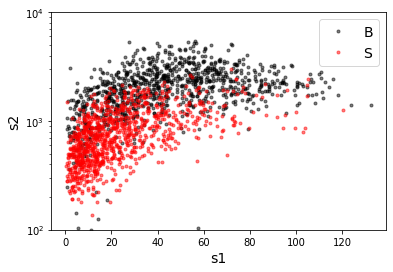

In [27]:
rnd = 100

B_pbot_plot, B_ptop_plot = shuffle(B_pbot, B_ptop, random_state=rnd)
S_pbot_plot, S_ptop_plot = shuffle(S_pbot, S_ptop, random_state=rnd)

plt.plot(B_pbot_plot[:1000], B_ptop_plot[:1000], '.', color='black', alpha=0.5, label='B')
plt.plot(S_pbot_plot[:1000], S_ptop_plot[:1000], '.', color='red', alpha=0.5, label='S')
plt.yscale('log')
# plt.xlim([0,100])
plt.ylim([100,10000])
plt.xlabel('s1',fontsize=14)
plt.ylabel('s2',fontsize=14)
plt.legend(fontsize=14)
plt.show()

###### Construct time diff between pulses

B_pdiffT.shape:  (32015,)
S_pdiffT.shape:  (32015,)


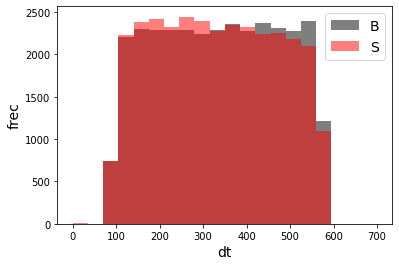

In [28]:
B_pdiffT = B_ppeakS2[:,0] - B_ppeakS1[:,0]
S_pdiffT = S_ppeakS2[:,0] - S_ppeakS1[:,0]

print('B_pdiffT.shape: ', B_pdiffT.shape)
print('S_pdiffT.shape: ', S_pdiffT.shape)


plt.hist(B_pdiffT, range=[0,700], bins=20, color='black', alpha=0.5, label='B')
plt.hist(S_pdiffT, range=[0,700], bins=20, color='red', alpha=0.5, label='S')
# plt.yscale('log')
# plt.xlim([0,100])
# plt.ylim([100,10000])
plt.xlabel('dt',fontsize=14)
plt.ylabel('frec',fontsize=14)
plt.legend(fontsize=14)
plt.show()

##### Remove some columns or features (if you want)

In [29]:
remove_col = [0]

B_pbot = B_pbot
B_ptop = B_ptop
B_ppeakS1 = np.delete(B_ppeakS1, remove_col, axis=1)
B_ppeakS2 = np.delete(B_ppeakS2, remove_col, axis=1)

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot
S_ptop = S_ptop
S_ppeakS1 = np.delete(S_ppeakS1, remove_col, axis=1)
S_ppeakS2 = np.delete(S_ppeakS2, remove_col, axis=1)

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

B_pbot.shape:  (32015,)
B_ptop.shape:  (32015,)
B_ppeakS1.shape : (32015, 7)
B_ppeakS2.shape:  (32015, 7)
S_pbot.shape:  (32015,)
S_ptop.shape:  (32015,)
S_ppeakS1.shape : (32015, 7)
S_ppeakS2.shape:  (32015, 7)


## 1. 16 variables + time diff

In [30]:
# concatenate the data
X_mon_B = np.concatenate([B_ppeakS1, B_ppeakS2, np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(B_ptop,(len(B_ptop),1)), np.reshape(B_pdiffT,(len(B_pdiffT),1)) ],axis=1)
X_mon_S = np.concatenate([S_ppeakS1, S_ppeakS2, np.reshape(S_pbot,(len(S_pbot),1)), np.reshape(S_ptop,(len(S_ptop),1)), np.reshape(S_pdiffT,(len(S_pdiffT),1)) ],axis=1)

# X_mon_B = np.reshape(B_pdiffT,(len(B_pdiffT),1))
# X_mon_S = np.reshape(S_pdiffT,(len(S_pdiffT),1))
print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)

# del B_ppeakS1
# del B_ppeakS2
# del B_pbot
# del B_ptop

# del S_ppeakS1
# del S_ppeakS2
# del S_pbot
# del S_ptop

X_mon = np.concatenate([X_mon_B, X_mon_S])

# X_mon = np.concatenate([np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(S_pbot,(len(S_pbot),1))])

print('X_mon.shape: ', X_mon.shape)
# del X_mon_B
# del X_mon_S


# labels
y_mon = np.concatenate([np.zeros(NUM_DAT),np.ones(NUM_DAT)])


# divide into train-val and test data samples
test_ratio = 0.25
val_ratio = 0.15


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

del X_mon
del y_mon

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

del X_mon_aux
del y_mon_aux

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

X_mon_B.shape:  (32015, 17)
X_mon_S.shape:  (32015, 17)
X_mon.shape:  (64030, 17)

X_mon_train :  (40818, 17)
y_mon_train :  (40818,)
X_mon_val :  (7204, 17)
y_mon_val :  (7204,)
X_mon_test :  (16008, 17)
y_mon_test :  (16008,)



## CLASSIFIERS

### XGBoost

[0]	validation_0-logloss:0.63108	validation_1-logloss:0.63185
[1]	validation_0-logloss:0.58032	validation_1-logloss:0.58187
[2]	validation_0-logloss:0.53735	validation_1-logloss:0.53885


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-logloss:0.50115	validation_1-logloss:0.50270
[4]	validation_0-logloss:0.46878	validation_1-logloss:0.47115
[5]	validation_0-logloss:0.44013	validation_1-logloss:0.44305
[6]	validation_0-logloss:0.41505	validation_1-logloss:0.41821
[7]	validation_0-logloss:0.39262	validation_1-logloss:0.39563
[8]	validation_0-logloss:0.37352	validation_1-logloss:0.37682
[9]	validation_0-logloss:0.35682	validation_1-logloss:0.36020
[10]	validation_0-logloss:0.34014	validation_1-logloss:0.34379
[11]	validation_0-logloss:0.32604	validation_1-logloss:0.33037
[12]	validation_0-logloss:0.31284	validation_1-logloss:0.31739
[13]	validation_0-logloss:0.30089	validation_1-logloss:0.30609
[14]	validation_0-logloss:0.29042	validation_1-logloss:0.29562
[15]	validation_0-logloss:0.28132	validation_1-logloss:0.28723
[16]	validation_0-logloss:0.27251	validation_1-logloss:0.27893
[17]	validation_0-logloss:0.26450	validation_1-logloss:0.27118
[18]	validation_0-logloss:0.25685	validation_1-logloss:0.26415

[133]	validation_0-logloss:0.14071	validation_1-logloss:0.18053
[134]	validation_0-logloss:0.14039	validation_1-logloss:0.18058
[135]	validation_0-logloss:0.14022	validation_1-logloss:0.18056
[136]	validation_0-logloss:0.13985	validation_1-logloss:0.18039
[137]	validation_0-logloss:0.13969	validation_1-logloss:0.18033
[138]	validation_0-logloss:0.13951	validation_1-logloss:0.18034
[139]	validation_0-logloss:0.13914	validation_1-logloss:0.18024
[140]	validation_0-logloss:0.13901	validation_1-logloss:0.18029
[141]	validation_0-logloss:0.13881	validation_1-logloss:0.18032
[142]	validation_0-logloss:0.13861	validation_1-logloss:0.18029
[143]	validation_0-logloss:0.13838	validation_1-logloss:0.18023
[144]	validation_0-logloss:0.13828	validation_1-logloss:0.18020
[145]	validation_0-logloss:0.13817	validation_1-logloss:0.18026
[146]	validation_0-logloss:0.13797	validation_1-logloss:0.18023
[147]	validation_0-logloss:0.13782	validation_1-logloss:0.18019
[148]	validation_0-logloss:0.13764	valid

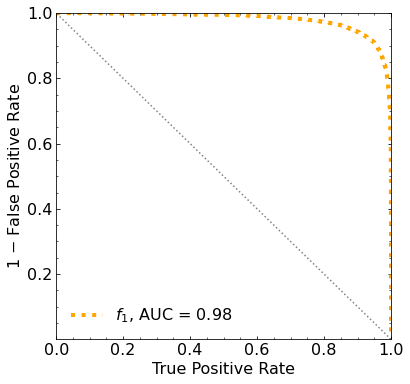

Classification score:


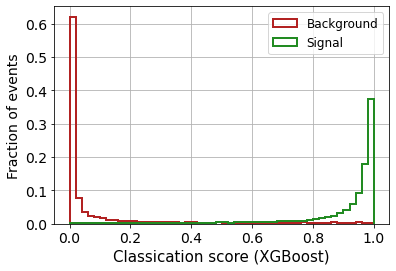


 ROC-AUC =  0.9792832808880081


In [31]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

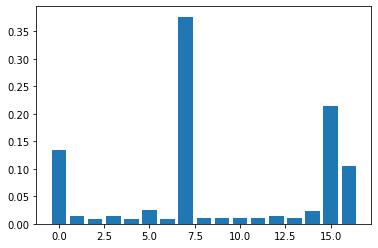

In [32]:
plt.bar(range(len(classifier.feature_importances_)), classifier.feature_importances_)
plt.show()

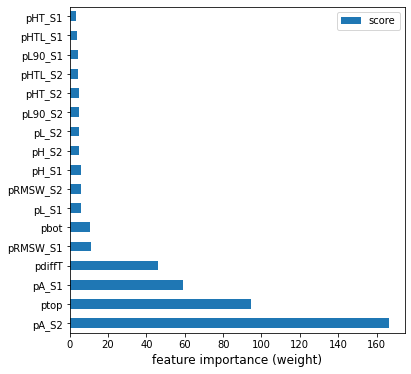

In [33]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
keys = ['pA_S1','pH_S1','pHT_S1','pL_S1','pL90_S1','pRMSW_S1','pHTL_S1','pA_S2','pH_S2','pHT_S2','pL_S2','pL90_S2','pRMSW_S2','pHTL_S2','pbot', 'ptop','pdiffT']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 40 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

In [34]:
keys

['pA_S1',
 'pH_S1',
 'pHT_S1',
 'pL_S1',
 'pL90_S1',
 'pRMSW_S1',
 'pHTL_S1',
 'pA_S2',
 'pH_S2',
 'pHT_S2',
 'pL_S2',
 'pL90_S2',
 'pRMSW_S2',
 'pHTL_S2',
 'pbot',
 'ptop',
 'pdiffT']

In [35]:

from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(classifier, X_mon_test, y_mon_test)


In [36]:


sorted_idx = classifier.feature_importances_.argsort()

sorted_idx_keys = []
for i in sorted_idx:
    sorted_idx_keys.append(keys[i])
    
sorted_idx_keys

['pHT_S1',
 'pHTL_S1',
 'pL90_S1',
 'pHTL_S2',
 'pHT_S2',
 'pL90_S2',
 'pL_S2',
 'pH_S2',
 'pH_S1',
 'pRMSW_S2',
 'pL_S1',
 'pbot',
 'pRMSW_S1',
 'pdiffT',
 'pA_S1',
 'ptop',
 'pA_S2']

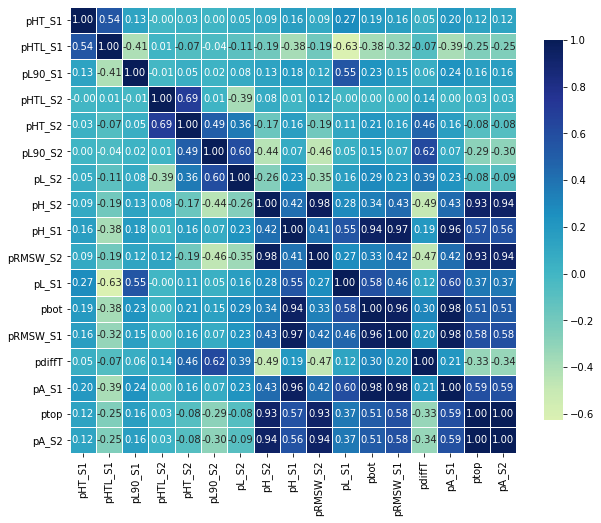

In [37]:
X = pd.DataFrame(X_mon_test, columns=keys)

def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();
    
correlation_heatmap(X[sorted_idx_keys])


In [38]:
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]] # range of our data (between 0 and 1 if its the ML output)

bins_to_test=range(1,500) # number of bins we are testing to see if condition holds

# FIND THE NUMBER OF BINS:
num_bins = max_num_bins(pred_XG_SM, B_expected, range_dat, MIN_EVS, bins_to_test)

print('\n FOR BIN LIKELIHOOD WE ARE SETTING:')
print('min number of Background events allowed per bin: ', MIN_EVS)
print('number of bins we are going to use: ', num_bins)
print('range of our data: ', range_dat)

At least 5 B events per bin, range = [[0, 1]]:
# bins:  17 OK

 FOR BIN LIKELIHOOD WE ARE SETTING:
min number of Background events allowed per bin:  5
number of bins we are going to use:  17
range of our data:  [[0, 1]]


In [91]:
num_bins = 10


 FINAL RESULT:

[0.14471617266696135, 0.14471617266696135, 0.2872621848964314, 0.42773178293650566, 0.9703553182977528, 1.9757062189252017, 3.948164624746508, 7.38202664914601, 12.769092735669188, 21.03203311771085]


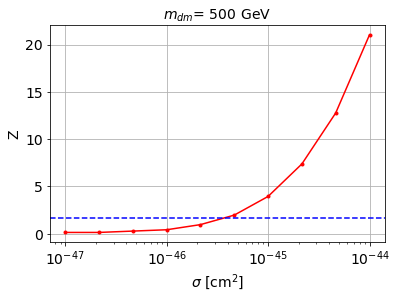


cross_BL_164:  3.5921973125774884e-46


In [90]:

# OPTION 0

store_Z_asimov = []


for s_it in range(len(S_expected)):

    Z_asimov = Z_BL_asimov(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, S_expected[s_it], num_bins, range_dat, MIN_EVS, linear_bins=True) 
    store_Z_asimov.append( Z_asimov )
    
    
print('\n FINAL RESULT:\n')
print(store_Z_asimov)

# plot
plt.plot(cross_factor*1e-45, store_Z_asimov, '.-', c='red')

plt.axhline(y=1.64, c='blue', linestyle='--')
plt.title('$m_{dm}$= %0.2d GeV' % mDM, fontsize=14)
plt.xscale('log')
plt.xlabel(r'$\sigma$ [cm$^2$]', fontsize=14)
plt.ylabel(r'Z', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()


# interpolate
f_Z = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_asimov), kind='linear')
# f_Z_up = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_asimov)[:,0] + np.array(store_Z_asimov)[:,1], kind='linear')
# f_Z_down = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_asimov)[:,0] - np.array(store_Z_asimov)[:,1], kind='linear')

# compute the cross section with Z=1.64
cross_BL_164 = 10**solvecross(f_Z, 1.64)
# cross_BL_164_up = 10**solvecross(f_Z_up, 1.64)
# cross_BL_164_down = 10**solvecross(f_Z_down, 1.64)

print('\ncross_BL_164: ', cross_BL_164)
# print('cross_BL_164_up: ', cross_BL_164_up)
# print('cross_BL_164_down: ', cross_BL_164_down)

B_expected:  643
S_expected:  1

SJAIJDISAODJIASJDOJSOAJDSJA
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.068


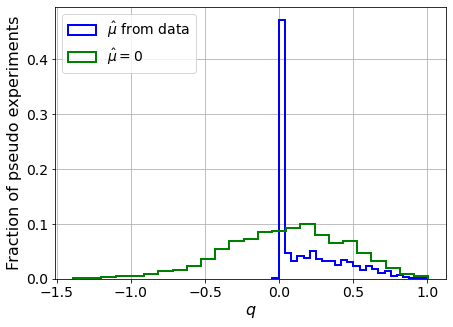

muhat mean:  0.45260193133047216
Z_bins:  0.25061993704857394
std Z_bins:  0.4661282827406882
Z_bins mu=0:  0.25061993704857394
std Z_bins mu=0:  0.7969605914322703

--------

B_expected:  643
S_expected:  1

SJAIJDISAODJIASJDOJSOAJDSJA
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.063


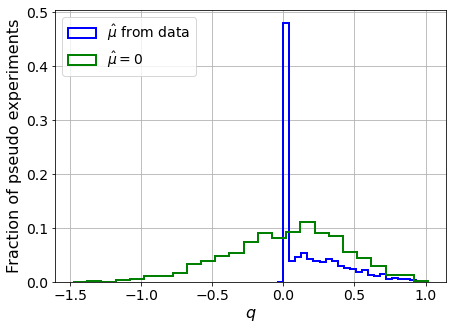

muhat mean:  0.4620330843116329
Z_bins:  0.25602679072833173
std Z_bins:  0.4382927630323255
Z_bins mu=0:  0.25602679072833173
std Z_bins mu=0:  0.7853486405552038

--------

B_expected:  643
S_expected:  2

SJAIJDISAODJIASJDOJSOAJDSJA
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.085


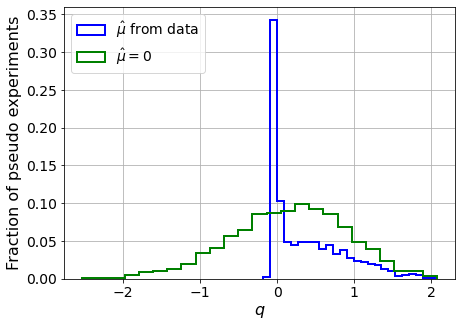

muhat mean:  0.4145901639344263
Z_bins:  0.4350351482695789
std Z_bins:  0.534131236743608
Z_bins mu=0:  0.4350351482695789
std Z_bins mu=0:  0.8649820346914029

--------

B_expected:  643
S_expected:  3

SJAIJDISAODJIASJDOJSOAJDSJA
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.067


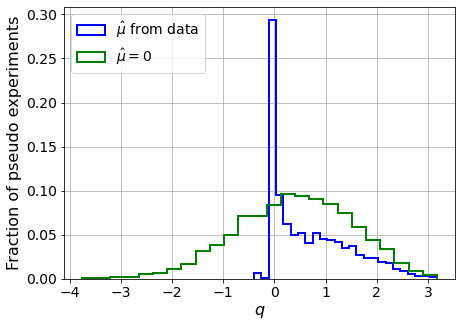

muhat mean:  0.3517416934619508
Z_bins:  0.6629794714505818
std Z_bins:  0.568273050894206
Z_bins mu=0:  0.6629794714505818
std Z_bins mu=0:  0.8482494178898611

--------

B_expected:  643
S_expected:  7

SJAIJDISAODJIASJDOJSOAJDSJA
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0645


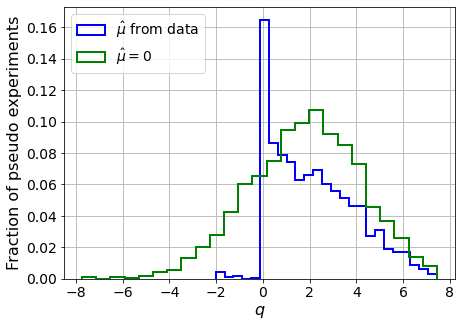

muhat mean:  0.21539283805451634
Z_bins:  1.3856123348570928
std Z_bins:  0.6549491769749131
Z_bins mu=0:  1.3856123348570928
std Z_bins mu=0:  0.852492007315595

--------

B_expected:  643
S_expected:  15

SJAIJDISAODJIASJDOJSOAJDSJA
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0725


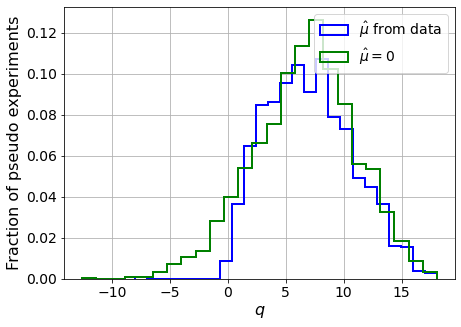

muhat mean:  0.10714285714285714
Z_bins:  2.616650072376846
std Z_bins:  0.7114734760911297
Z_bins mu=0:  2.6169950393191477
std Z_bins mu=0:  0.8378272712028779

--------

B_expected:  643
S_expected:  33

SJAIJDISAODJIASJDOJSOAJDSJA
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.07


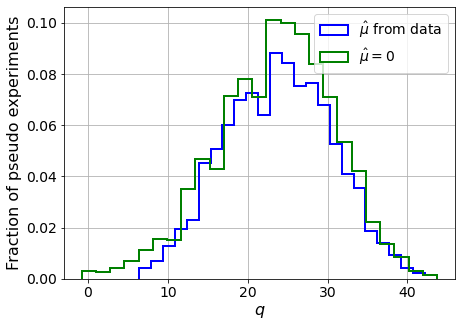

muhat mean:  0.038118279569892485
Z_bins:  4.89956918908743
std Z_bins:  0.688655538824015
Z_bins mu=0:  4.903738923674474
std Z_bins mu=0:  0.7546863729298037

--------

B_expected:  643
S_expected:  72

SJAIJDISAODJIASJDOJSOAJDSJA
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0805


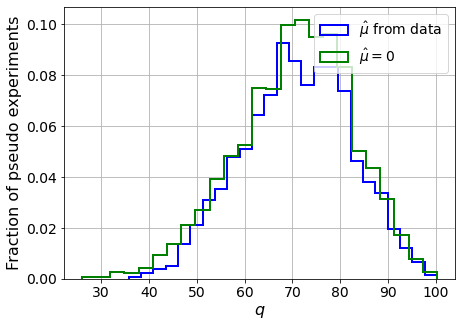

muhat mean:  0.017237629146275156
Z_bins:  8.432100832505869
std Z_bins:  0.667904635551179
Z_bins mu=0:  8.443470166881806
std Z_bins mu=0:  0.7109645627816374

--------

B_expected:  643
S_expected:  154

SJAIJDISAODJIASJDOJSOAJDSJA
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0705


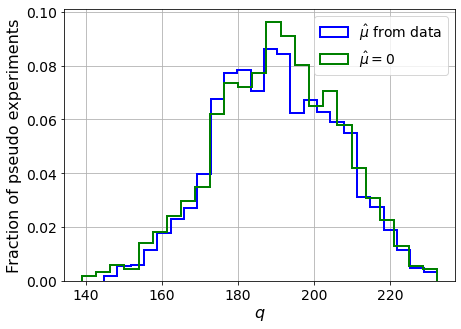

muhat mean:  0.007584722969338355
Z_bins:  13.780603734239962
std Z_bins:  0.5817046878792624
Z_bins mu=0:  13.806820788619358
std Z_bins mu=0:  0.593973530760178

--------

B_expected:  643
S_expected:  332

SJAIJDISAODJIASJDOJSOAJDSJA
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0715


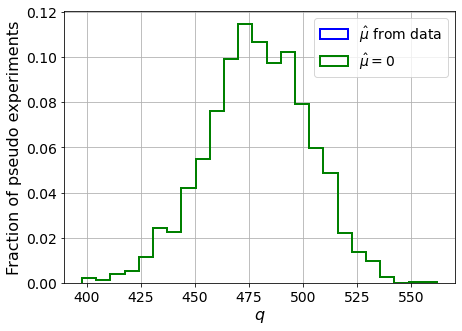

muhat mean:  -0.05
Z_bins:  21.88288467986546
std Z_bins:  0.5389769861285583
Z_bins mu=0:  21.88288467986546
std Z_bins mu=0:  0.5389769861285583

--------


 FINAL RESULT:

[[0.25061993704857394, 0.4661282827406882, 0.45260193133047216, 0.25061993704857394, 0.7969605914322703], [0.25602679072833173, 0.4382927630323255, 0.4620330843116329, 0.25602679072833173, 0.7853486405552038], [0.4350351482695789, 0.534131236743608, 0.4145901639344263, 0.4350351482695789, 0.8649820346914029], [0.6629794714505818, 0.568273050894206, 0.3517416934619508, 0.6629794714505818, 0.8482494178898611], [1.3856123348570928, 0.6549491769749131, 0.21539283805451634, 1.3856123348570928, 0.852492007315595], [2.616650072376846, 0.7114734760911297, 0.10714285714285714, 2.6169950393191477, 0.8378272712028779], [4.89956918908743, 0.688655538824015, 0.038118279569892485, 4.903738923674474, 0.7546863729298037], [8.432100832505869, 0.667904635551179, 0.017237629146275156, 8.443470166881806, 0.7109645627816374], [13.7806

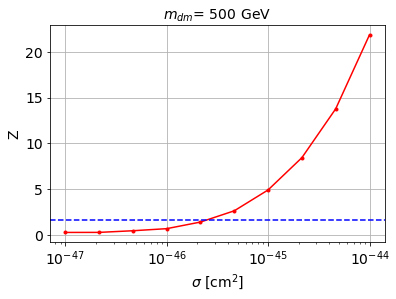


cross_BL_164:  2.524730143850727e-46
cross_BL_164_up:  1.4735078705634294e-46
cross_BL_164_down:  3.903085808624568e-46


In [95]:

# OPTION 1 (mu_hat with a grid, fast)
store_Z_BL = []


for s_it in range(len(S_expected)):
    
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[s_it])
    print('')

    Z_BL = BL_test_fast(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, S_expected[s_it], num_pseudo, num_bins, range_dat, MIN_EVS, linear_bins=True) 
    
    store_Z_BL.append( list(Z_BL) )
    
    print('muhat mean: ', Z_BL[2])
    print('Z_bins: ', Z_BL[0])
    print('std Z_bins: ', Z_BL[1])
    print('Z_bins mu=0: ', Z_BL[3])
    print('std Z_bins mu=0: ', Z_BL[4])
    print('')
    print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)


# plot
plt.plot(cross_factor*1e-45, np.array(store_Z_BL)[:,0], '.-', c='red')

plt.axhline(y=1.64, c='blue', linestyle='--')
plt.title('$m_{dm}$= %0.2d GeV' % mDM, fontsize=14)
plt.xscale('log')
plt.xlabel(r'$\sigma$ [cm$^2$]', fontsize=14)
plt.ylabel(r'Z', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()


# interpolate
f_Z = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0], kind='linear')
f_Z_up = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0] + np.array(store_Z_BL)[:,1], kind='linear')
f_Z_down = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0] - np.array(store_Z_BL)[:,1], kind='linear')

# compute the cross section with Z=1.64
cross_BL_164 = 10**solvecross(f_Z, 1.64)
cross_BL_164_up = 10**solvecross(f_Z_up, 1.64)
cross_BL_164_down = 10**solvecross(f_Z_down, 1.64)

print('\ncross_BL_164: ', cross_BL_164)
print('cross_BL_164_up: ', cross_BL_164_up)
print('cross_BL_164_down: ', cross_BL_164_down)

B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.073


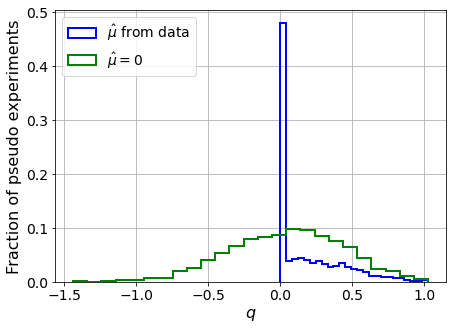

muhat mean:  0.03582556266841789
Z_bins:  0.25098584182043393
std Z_bins:  0.463671811497002
Z_bins mu=0:  0.25098584182043393
std Z_bins mu=0:  0.7909452124096245

--------

B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.062


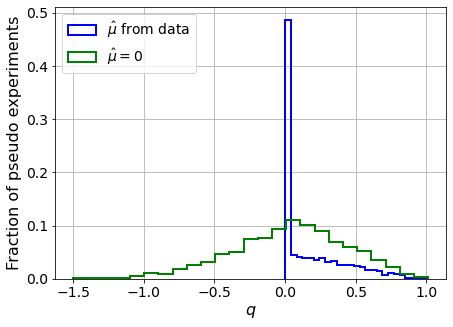

muhat mean:  0.17463241915168143
Z_bins:  0.22782176183975145
std Z_bins:  0.5058664615173685
Z_bins mu=0:  0.22782176183975145
std Z_bins mu=0:  0.8986111583245469

--------

B_expected:  643
S_expected:  2

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.085


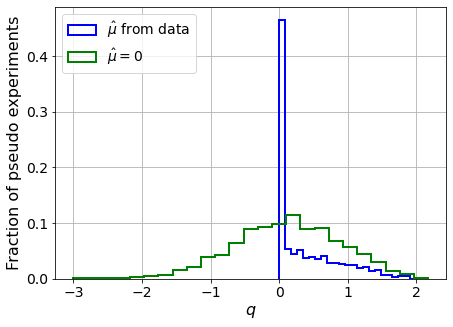

muhat mean:  0.1678583509604229
Z_bins:  0.3720011626474555
std Z_bins:  0.6357274798888295
Z_bins mu=0:  0.37008724779094915
std Z_bins mu=0:  1.0521533417857847

--------

B_expected:  643
S_expected:  3

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0645


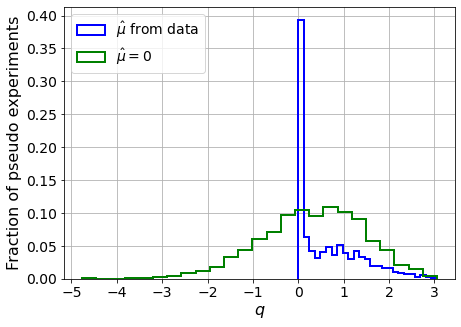

muhat mean:  0.0814545084052933
Z_bins:  0.6102850879174355
std Z_bins:  0.581239508249569
Z_bins mu=0:  0.6102850879174355
std Z_bins mu=0:  0.9237975840143634

--------

B_expected:  643
S_expected:  7

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0705


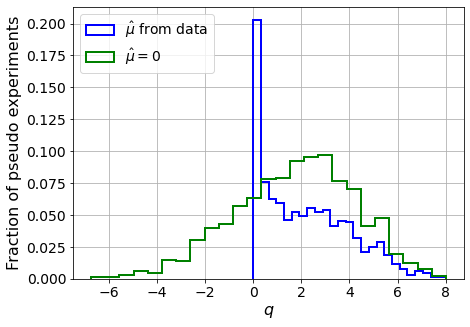

muhat mean:  0.015528965553901932
Z_bins:  1.3904216247266459
std Z_bins:  0.6591910438782238
Z_bins mu=0:  1.3904216247266459
std Z_bins mu=0:  0.8948077302222769

--------

B_expected:  643
S_expected:  15

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.074


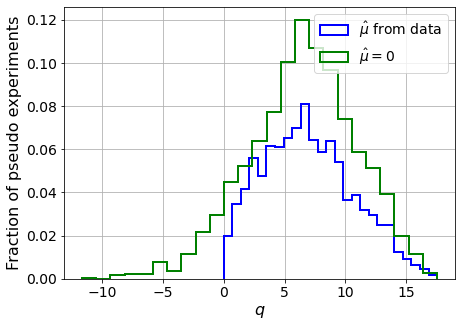

muhat mean:  0.016337574678369902
Z_bins:  2.59432268038233
std Z_bins:  0.7121314596588608
Z_bins mu=0:  2.59432268038233
std Z_bins mu=0:  0.8537412886853986

--------

B_expected:  643
S_expected:  33

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.073


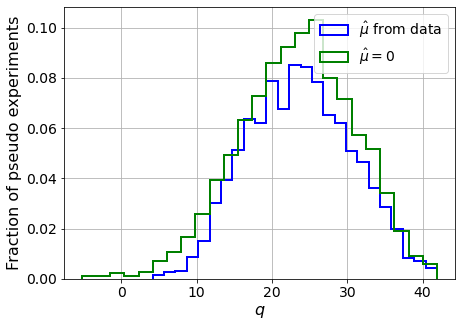

muhat mean:  0.002199201328048085
Z_bins:  4.852729481299783
std Z_bins:  0.7096786678177083
Z_bins mu=0:  4.852231313455334
std Z_bins mu=0:  0.7810954183691144

--------

B_expected:  643
S_expected:  72

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0635


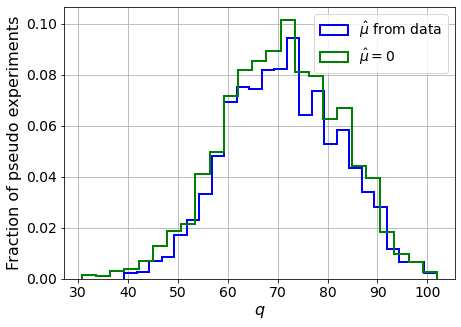

muhat mean:  9.480776105220996e-05
Z_bins:  8.435023179546771
std Z_bins:  0.6572611042652878
Z_bins mu=0:  8.43392682178427
std Z_bins mu=0:  0.694907959243682

--------

B_expected:  643
S_expected:  154

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.065


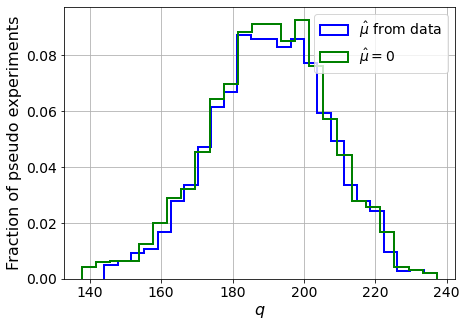

muhat mean:  0.0003324189981594131
Z_bins:  13.803159816396947
std Z_bins:  0.591026361678388
Z_bins mu=0:  13.800757753250222
std Z_bins mu=0:  0.6161669059278242

--------

B_expected:  643
S_expected:  332

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.075


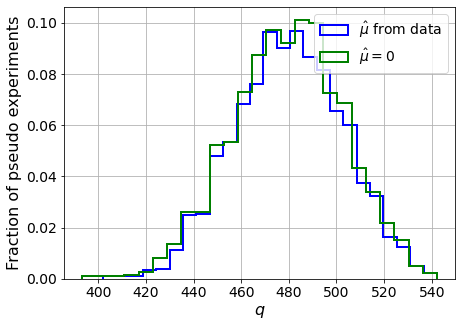

muhat mean:  0.0003138778555461754
Z_bins:  21.912934408884375
std Z_bins:  0.514518375340679
Z_bins mu=0:  21.91253605564501
std Z_bins mu=0:  0.5292306848388519

--------


 FINAL RESULT:

[[0.25098584182043393, 0.463671811497002, 0.03582556266841789, 0.25098584182043393, 0.7909452124096245], [0.22782176183975145, 0.5058664615173685, 0.17463241915168143, 0.22782176183975145, 0.8986111583245469], [0.3720011626474555, 0.6357274798888295, 0.1678583509604229, 0.37008724779094915, 1.0521533417857847], [0.6102850879174355, 0.581239508249569, 0.0814545084052933, 0.6102850879174355, 0.9237975840143634], [1.3904216247266459, 0.6591910438782238, 0.015528965553901932, 1.3904216247266459, 0.8948077302222769], [2.59432268038233, 0.7121314596588608, 0.016337574678369902, 2.59432268038233, 0.8537412886853986], [4.852729481299783, 0.7096786678177083, 0.002199201328048085, 4.852231313455334, 0.7810954183691144], [8.435023179546771, 0.6572611042652878, 9.480776105220996e-05, 8.43392682178427, 0.694907

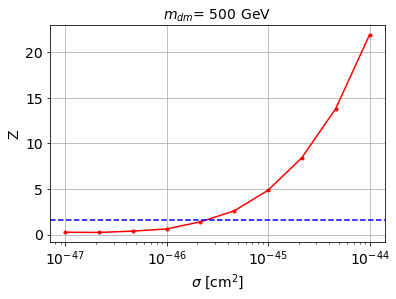


cross_BL_164:  2.5260155242494657e-46
cross_BL_164_up:  1.4935335599159894e-46
cross_BL_164_down:  3.949343465439275e-46


In [96]:
# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []


for s_it in range(len(S_expected)):
    
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[s_it])
    print('')

    Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, S_expected[s_it], num_pseudo, num_bins, range_dat, MIN_EVS, linear_bins=True) 
    
    store_Z_BL.append( list(Z_BL) )
    
    print('muhat mean: ', Z_BL[2])
    print('Z_bins: ', Z_BL[0])
    print('std Z_bins: ', Z_BL[1])
    print('Z_bins mu=0: ', Z_BL[3])
    print('std Z_bins mu=0: ', Z_BL[4])
    print('')
    print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)


# plot
plt.plot(cross_factor*1e-45, np.array(store_Z_BL)[:,0], '.-', c='red')

plt.axhline(y=1.64, c='blue', linestyle='--')
plt.title('$m_{dm}$= %0.2d GeV' % mDM, fontsize=14)
plt.xscale('log')
plt.xlabel(r'$\sigma$ [cm$^2$]', fontsize=14)
plt.ylabel(r'Z', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()


# interpolate
f_Z = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0], kind='linear')
f_Z_up = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0] + np.array(store_Z_BL)[:,1], kind='linear')
f_Z_down = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0] - np.array(store_Z_BL)[:,1], kind='linear')

# compute the cross section with Z=1.64
cross_BL_164 = 10**solvecross(f_Z, 1.64)
cross_BL_164_up = 10**solvecross(f_Z_up, 1.64)
cross_BL_164_down = 10**solvecross(f_Z_down, 1.64)

print('\ncross_BL_164: ', cross_BL_164)
print('cross_BL_164_up: ', cross_BL_164_up)
print('cross_BL_164_down: ', cross_BL_164_down)

### DNN

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 72        
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5

319/319 [==============================] - 0s 544us/step - loss: 0.3233 - accuracy: 0.8712 - val_loss: 0.3035 - val_accuracy: 0.8719
Epoch 105/500
319/319 [==============================] - 0s 525us/step - loss: 0.3183 - accuracy: 0.8716 - val_loss: 0.3243 - val_accuracy: 0.8576
Epoch 106/500
319/319 [==============================] - 0s 550us/step - loss: 0.3177 - accuracy: 0.8721 - val_loss: 0.3064 - val_accuracy: 0.8674
Epoch 107/500
319/319 [==============================] - 0s 542us/step - loss: 0.3127 - accuracy: 0.8753 - val_loss: 0.3012 - val_accuracy: 0.8715
Epoch 108/500
319/319 [==============================] - 0s 559us/step - loss: 0.3138 - accuracy: 0.8740 - val_loss: 0.2767 - val_accuracy: 0.8870
Epoch 109/500
319/319 [==============================] - 0s 532us/step - loss: 0.3160 - accuracy: 0.8732 - val_loss: 0.2790 - val_accuracy: 0.8871
Epoch 110/500
319/319 [==============================] - 0s 560us/step - loss: 0.3074 - accuracy: 0.8767 - val_loss: 0.3110 - val_ac

Epoch 160/500
319/319 [==============================] - 0s 538us/step - loss: 0.2999 - accuracy: 0.8795 - val_loss: 0.3517 - val_accuracy: 0.8366
Epoch 161/500
319/319 [==============================] - 0s 538us/step - loss: 0.2926 - accuracy: 0.8821 - val_loss: 0.3052 - val_accuracy: 0.8665
Epoch 162/500
319/319 [==============================] - 0s 533us/step - loss: 0.2979 - accuracy: 0.8813 - val_loss: 0.2863 - val_accuracy: 0.8769
Epoch 163/500
319/319 [==============================] - 0s 538us/step - loss: 0.2940 - accuracy: 0.8840 - val_loss: 0.2820 - val_accuracy: 0.8808
Epoch 164/500
319/319 [==============================] - 0s 525us/step - loss: 0.2907 - accuracy: 0.8844 - val_loss: 0.2967 - val_accuracy: 0.8730
Epoch 165/500
319/319 [==============================] - 0s 529us/step - loss: 0.2952 - accuracy: 0.8811 - val_loss: 0.2546 - val_accuracy: 0.8963
Epoch 166/500
319/319 [==============================] - 0s 523us/step - loss: 0.2978 - accuracy: 0.8822 - val_loss: 0

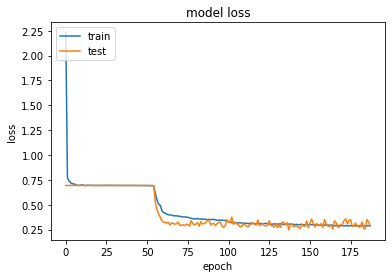

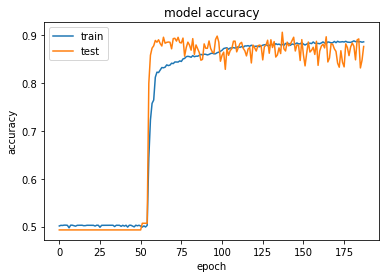

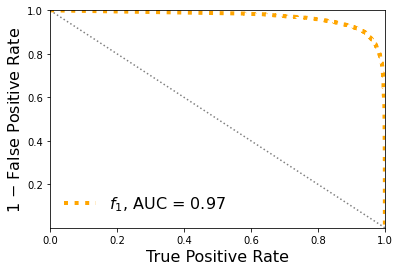

Classification score:


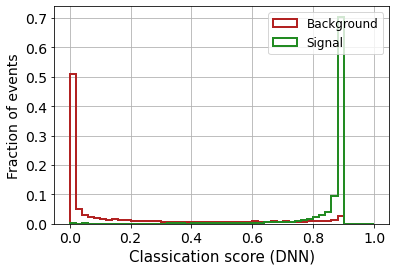


 ROC-AUC =  0.9703067186322858


In [25]:

# define the keras model
model = Sequential()
model.add(Dense(4, input_shape=(X_mon_train.shape[1],), activation='relu'))
model.add(Dropout(0.20))
# model.add(Dense(8, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

### CNN

In [26]:
# prepare the dataset
X_mon_train_cn = X_mon_train.reshape(X_mon_train.shape[0], X_mon_train.shape[1], 1)
X_mon_test_cn = X_mon_test.reshape(X_mon_test.shape[0], X_mon_test.shape[1], 1)
X_mon_val_cn = X_mon_val.reshape(X_mon_val.shape[0], X_mon_val.shape[1], 1)

Epoch 1/500
319/319 [==============================] - 2s 1ms/step - loss: 21.0824 - accuracy: 0.5060 - val_loss: 0.7000 - val_accuracy: 0.5104
Epoch 2/500
319/319 [==============================] - 0s 929us/step - loss: 0.7009 - accuracy: 0.4981 - val_loss: 0.6993 - val_accuracy: 0.5104
Epoch 3/500
319/319 [==============================] - 0s 923us/step - loss: 0.7002 - accuracy: 0.4982 - val_loss: 0.7298 - val_accuracy: 0.5105
Epoch 4/500
319/319 [==============================] - 0s 919us/step - loss: 0.7008 - accuracy: 0.5047 - val_loss: 0.6984 - val_accuracy: 0.4931
Epoch 5/500
319/319 [==============================] - 0s 960us/step - loss: 0.6990 - accuracy: 0.5058 - val_loss: 0.6985 - val_accuracy: 0.4931
Epoch 6/500
319/319 [==============================] - 0s 930us/step - loss: 0.6986 - accuracy: 0.5047 - val_loss: 0.6981 - val_accuracy: 0.4931
Epoch 7/500
319/319 [==============================] - 0s 931us/step - loss: 0.6986 - accuracy: 0.5012 - val_loss: 0.6971 - val_acc

319/319 [==============================] - 0s 980us/step - loss: 0.6906 - accuracy: 0.5077 - val_loss: 0.6914 - val_accuracy: 0.5107
Epoch 114/500
319/319 [==============================] - 0s 984us/step - loss: 0.6909 - accuracy: 0.5015 - val_loss: 0.6914 - val_accuracy: 0.4931
Epoch 115/500
319/319 [==============================] - 0s 957us/step - loss: 0.6911 - accuracy: 0.5060 - val_loss: 0.6914 - val_accuracy: 0.4931
Epoch 116/500
319/319 [==============================] - 0s 975us/step - loss: 0.6904 - accuracy: 0.5015 - val_loss: 0.6911 - val_accuracy: 0.5107
Epoch 117/500
319/319 [==============================] - 0s 975us/step - loss: 0.6904 - accuracy: 0.5006 - val_loss: 0.6912 - val_accuracy: 0.5103
Epoch 118/500
319/319 [==============================] - 0s 946us/step - loss: 0.6904 - accuracy: 0.5044 - val_loss: 0.6916 - val_accuracy: 0.4931
Epoch 119/500
319/319 [==============================] - 0s 933us/step - loss: 0.6904 - accuracy: 0.4967 - val_loss: 0.6924 - val_ac

Epoch 169/500
319/319 [==============================] - 0s 942us/step - loss: 0.3739 - accuracy: 0.8432 - val_loss: 0.2685 - val_accuracy: 0.9173
Epoch 170/500
319/319 [==============================] - 0s 987us/step - loss: 0.3837 - accuracy: 0.8372 - val_loss: 0.2628 - val_accuracy: 0.9203
Epoch 171/500
319/319 [==============================] - 0s 985us/step - loss: 0.3771 - accuracy: 0.8400 - val_loss: 0.2530 - val_accuracy: 0.9253
Epoch 172/500
319/319 [==============================] - 0s 968us/step - loss: 0.3799 - accuracy: 0.8389 - val_loss: 0.2522 - val_accuracy: 0.9266
Epoch 173/500
319/319 [==============================] - 0s 960us/step - loss: 0.3790 - accuracy: 0.8383 - val_loss: 0.2515 - val_accuracy: 0.9263
Epoch 174/500
319/319 [==============================] - 0s 1000us/step - loss: 0.3828 - accuracy: 0.8377 - val_loss: 0.2580 - val_accuracy: 0.9205
Epoch 175/500
319/319 [==============================] - 0s 978us/step - loss: 0.3787 - accuracy: 0.8399 - val_loss: 

Epoch 225/500
319/319 [==============================] - 0s 961us/step - loss: 0.3782 - accuracy: 0.8393 - val_loss: 0.2486 - val_accuracy: 0.9264
Epoch 226/500
319/319 [==============================] - 0s 953us/step - loss: 0.3741 - accuracy: 0.8435 - val_loss: 0.2488 - val_accuracy: 0.9259
Epoch 227/500
319/319 [==============================] - 0s 961us/step - loss: 0.3784 - accuracy: 0.8391 - val_loss: 0.2537 - val_accuracy: 0.9231
Epoch 228/500
319/319 [==============================] - 0s 963us/step - loss: 0.3826 - accuracy: 0.8390 - val_loss: 0.2482 - val_accuracy: 0.9273
Epoch 229/500
319/319 [==============================] - 0s 959us/step - loss: 0.3780 - accuracy: 0.8399 - val_loss: 0.2526 - val_accuracy: 0.9255
Epoch 230/500
319/319 [==============================] - 0s 1ms/step - loss: 0.3764 - accuracy: 0.8408 - val_loss: 0.2487 - val_accuracy: 0.9268
Epoch 231/500
319/319 [==============================] - 0s 1ms/step - loss: 0.3806 - accuracy: 0.8372 - val_loss: 0.253

Epoch 281/500
319/319 [==============================] - 0s 929us/step - loss: 0.3831 - accuracy: 0.8367 - val_loss: 0.2505 - val_accuracy: 0.9274
Epoch 282/500
319/319 [==============================] - 0s 944us/step - loss: 0.3726 - accuracy: 0.8430 - val_loss: 0.2472 - val_accuracy: 0.9266
Epoch 283/500
319/319 [==============================] - 0s 946us/step - loss: 0.3800 - accuracy: 0.8374 - val_loss: 0.2497 - val_accuracy: 0.9266
Epoch 284/500
319/319 [==============================] - 0s 935us/step - loss: 0.3736 - accuracy: 0.8422 - val_loss: 0.2716 - val_accuracy: 0.9149
Epoch 285/500
319/319 [==============================] - 0s 943us/step - loss: 0.3797 - accuracy: 0.8395 - val_loss: 0.2522 - val_accuracy: 0.9252
Epoch 286/500
319/319 [==============================] - 0s 946us/step - loss: 0.3726 - accuracy: 0.8441 - val_loss: 0.2486 - val_accuracy: 0.9266
Epoch 287/500
319/319 [==============================] - 0s 957us/step - loss: 0.3733 - accuracy: 0.8436 - val_loss: 0

Epoch 337/500
319/319 [==============================] - 0s 923us/step - loss: 0.2673 - accuracy: 0.9023 - val_loss: 0.2148 - val_accuracy: 0.9246
Epoch 338/500
319/319 [==============================] - 0s 938us/step - loss: 0.2618 - accuracy: 0.9025 - val_loss: 0.2085 - val_accuracy: 0.9262
Epoch 339/500
319/319 [==============================] - 0s 938us/step - loss: 0.2631 - accuracy: 0.9023 - val_loss: 0.2140 - val_accuracy: 0.9249
Epoch 340/500
319/319 [==============================] - 0s 944us/step - loss: 0.2676 - accuracy: 0.8992 - val_loss: 0.2228 - val_accuracy: 0.9185
Epoch 341/500
319/319 [==============================] - 0s 945us/step - loss: 0.2632 - accuracy: 0.9026 - val_loss: 0.2072 - val_accuracy: 0.9263
Epoch 342/500
319/319 [==============================] - 0s 932us/step - loss: 0.2631 - accuracy: 0.9026 - val_loss: 0.2130 - val_accuracy: 0.9232
Epoch 343/500
319/319 [==============================] - 0s 950us/step - loss: 0.2611 - accuracy: 0.9034 - val_loss: 0

Epoch 393/500
319/319 [==============================] - 0s 942us/step - loss: 0.2603 - accuracy: 0.9039 - val_loss: 0.2100 - val_accuracy: 0.9237
Epoch 394/500
319/319 [==============================] - 0s 982us/step - loss: 0.2620 - accuracy: 0.9027 - val_loss: 0.2076 - val_accuracy: 0.9262
Epoch 395/500
319/319 [==============================] - 0s 954us/step - loss: 0.2593 - accuracy: 0.9030 - val_loss: 0.2099 - val_accuracy: 0.9255
Epoch 396/500
319/319 [==============================] - 0s 932us/step - loss: 0.2659 - accuracy: 0.9005 - val_loss: 0.2068 - val_accuracy: 0.9259
Epoch 397/500
319/319 [==============================] - 0s 939us/step - loss: 0.2611 - accuracy: 0.9037 - val_loss: 0.2135 - val_accuracy: 0.9252
Epoch 398/500
319/319 [==============================] - 0s 939us/step - loss: 0.2570 - accuracy: 0.9043 - val_loss: 0.2141 - val_accuracy: 0.9224
Epoch 399/500
319/319 [==============================] - 0s 939us/step - loss: 0.2576 - accuracy: 0.9043 - val_loss: 0

Epoch 449/500
319/319 [==============================] - 0s 984us/step - loss: 0.2555 - accuracy: 0.9057 - val_loss: 0.2066 - val_accuracy: 0.9264
Epoch 450/500
319/319 [==============================] - 0s 964us/step - loss: 0.2596 - accuracy: 0.9041 - val_loss: 0.2086 - val_accuracy: 0.9267
Epoch 451/500
319/319 [==============================] - 0s 934us/step - loss: 0.2704 - accuracy: 0.8998 - val_loss: 0.2107 - val_accuracy: 0.9246
Epoch 452/500
319/319 [==============================] - 0s 944us/step - loss: 0.2586 - accuracy: 0.9036 - val_loss: 0.2066 - val_accuracy: 0.9273
Epoch 453/500
319/319 [==============================] - 0s 934us/step - loss: 0.2564 - accuracy: 0.9059 - val_loss: 0.2070 - val_accuracy: 0.9273
Epoch 454/500
319/319 [==============================] - 0s 947us/step - loss: 0.2640 - accuracy: 0.9014 - val_loss: 0.2048 - val_accuracy: 0.9268
Epoch 455/500
319/319 [==============================] - 0s 936us/step - loss: 0.2584 - accuracy: 0.9051 - val_loss: 0

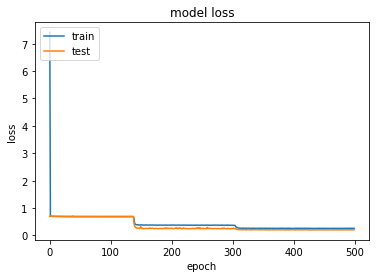

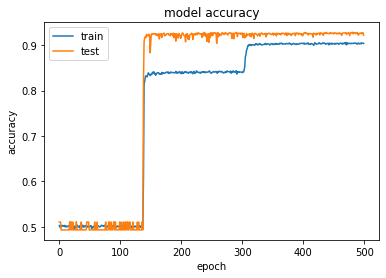

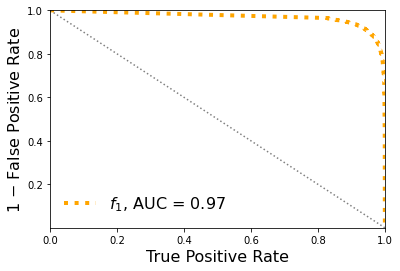

Classification score:


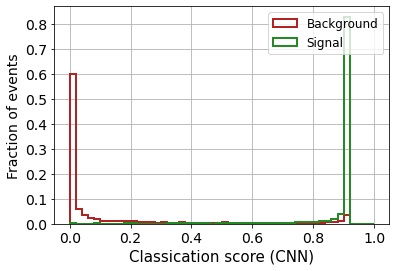


 ROC-AUC =  0.9701441211867984


In [27]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

## 2. Remove time diff between pulses

In [28]:
# concatenate the data
X_mon_B = np.concatenate([B_ppeakS1, B_ppeakS2, np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(B_ptop,(len(B_ptop),1)) ],axis=1)
X_mon_S = np.concatenate([S_ppeakS1, S_ppeakS2, np.reshape(S_pbot,(len(S_pbot),1)), np.reshape(S_ptop,(len(S_ptop),1)) ],axis=1)

print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)

# del B_ppeakS1
# del B_ppeakS2
# del B_pbot
# del B_ptop

# del S_ppeakS1
# del S_ppeakS2
# del S_pbot
# del S_ptop

X_mon = np.concatenate([X_mon_B, X_mon_S])

# X_mon = np.concatenate([np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(S_pbot,(len(S_pbot),1))])

print('X_mon.shape: ', X_mon.shape)
# del X_mon_B
# del X_mon_S


# labels
y_mon = np.concatenate([np.zeros(NUM_DAT),np.ones(NUM_DAT)])


# divide into train-val and test data samples
test_ratio = 0.25
val_ratio = 0.15


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

del X_mon
del y_mon

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

del X_mon_aux
del y_mon_aux

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

X_mon_B.shape:  (32015, 16)
X_mon_S.shape:  (32015, 16)
X_mon.shape:  (64030, 16)

X_mon_train :  (40818, 16)
y_mon_train :  (40818,)
X_mon_val :  (7204, 16)
y_mon_val :  (7204,)
X_mon_test :  (16008, 16)
y_mon_test :  (16008,)



### XGBoost

[0]	validation_0-logloss:0.63859	validation_1-logloss:0.63816
[1]	validation_0-logloss:0.59342	validation_1-logloss:0.59304
[2]	validation_0-logloss:0.55524	validation_1-logloss:0.55479
[3]	validation_0-logloss:0.52312	validation_1-logloss:0.52255


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-logloss:0.49573	validation_1-logloss:0.49515
[5]	validation_0-logloss:0.47116	validation_1-logloss:0.47099
[6]	validation_0-logloss:0.45006	validation_1-logloss:0.44983
[7]	validation_0-logloss:0.43166	validation_1-logloss:0.43178
[8]	validation_0-logloss:0.41603	validation_1-logloss:0.41619
[9]	validation_0-logloss:0.40144	validation_1-logloss:0.40172
[10]	validation_0-logloss:0.38887	validation_1-logloss:0.38941
[11]	validation_0-logloss:0.37768	validation_1-logloss:0.37855
[12]	validation_0-logloss:0.36730	validation_1-logloss:0.36815
[13]	validation_0-logloss:0.35824	validation_1-logloss:0.35961
[14]	validation_0-logloss:0.34996	validation_1-logloss:0.35128
[15]	validation_0-logloss:0.34252	validation_1-logloss:0.34433
[16]	validation_0-logloss:0.33609	validation_1-logloss:0.33832
[17]	validation_0-logloss:0.32992	validation_1-logloss:0.33248
[18]	validation_0-logloss:0.32449	validation_1-logloss:0.32742
[19]	validation_0-logloss:0.31947	validation_1-logloss:0.3229

[134]	validation_0-logloss:0.21688	validation_1-logloss:0.25912
[135]	validation_0-logloss:0.21657	validation_1-logloss:0.25903
[136]	validation_0-logloss:0.21619	validation_1-logloss:0.25900
[137]	validation_0-logloss:0.21579	validation_1-logloss:0.25893
[138]	validation_0-logloss:0.21550	validation_1-logloss:0.25904
[139]	validation_0-logloss:0.21504	validation_1-logloss:0.25900
[140]	validation_0-logloss:0.21464	validation_1-logloss:0.25911
[141]	validation_0-logloss:0.21432	validation_1-logloss:0.25916
[142]	validation_0-logloss:0.21402	validation_1-logloss:0.25910
[143]	validation_0-logloss:0.21376	validation_1-logloss:0.25890
[144]	validation_0-logloss:0.21345	validation_1-logloss:0.25883
[145]	validation_0-logloss:0.21313	validation_1-logloss:0.25877
[146]	validation_0-logloss:0.21292	validation_1-logloss:0.25874
[147]	validation_0-logloss:0.21246	validation_1-logloss:0.25860
[148]	validation_0-logloss:0.21231	validation_1-logloss:0.25858
[149]	validation_0-logloss:0.21202	valid

[263]	validation_0-logloss:0.18432	validation_1-logloss:0.25621
[264]	validation_0-logloss:0.18411	validation_1-logloss:0.25617
[265]	validation_0-logloss:0.18399	validation_1-logloss:0.25619
[266]	validation_0-logloss:0.18388	validation_1-logloss:0.25622
[267]	validation_0-logloss:0.18384	validation_1-logloss:0.25622
[268]	validation_0-logloss:0.18367	validation_1-logloss:0.25609
[269]	validation_0-logloss:0.18346	validation_1-logloss:0.25596
[270]	validation_0-logloss:0.18331	validation_1-logloss:0.25602
[271]	validation_0-logloss:0.18304	validation_1-logloss:0.25600
[272]	validation_0-logloss:0.18290	validation_1-logloss:0.25602
[273]	validation_0-logloss:0.18264	validation_1-logloss:0.25601
[274]	validation_0-logloss:0.18249	validation_1-logloss:0.25598
[275]	validation_0-logloss:0.18233	validation_1-logloss:0.25600
[276]	validation_0-logloss:0.18206	validation_1-logloss:0.25590
[277]	validation_0-logloss:0.18178	validation_1-logloss:0.25589
[278]	validation_0-logloss:0.18142	valid

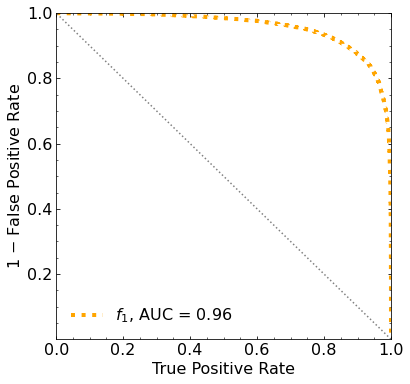

Classification score:


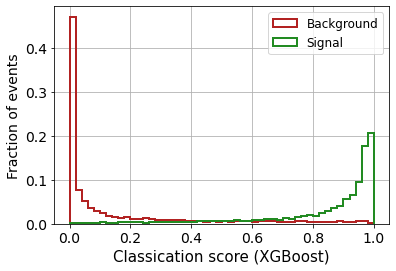


 ROC-AUC =  0.9567148147737076


In [29]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

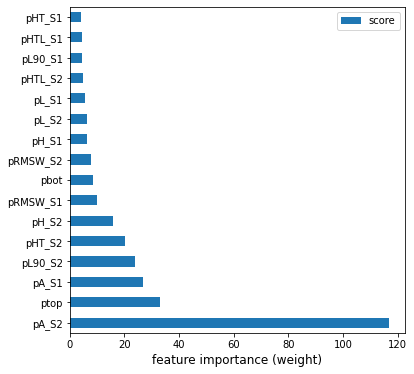

In [30]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
# keys = list(feature_important.keys())
keys = ['pA_S1','pH_S1','pHT_S1','pL_S1','pL90_S1','pRMSW_S1','pHTL_S1','pA_S2','pH_S2','pHT_S2','pL_S2','pL90_S2','pRMSW_S2','pHTL_S2','pbot', 'ptop']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 40 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

### DNN

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 4)                 68        
_________________________________________________________________
dropout_11 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 16)                80        
_________________________________________________________________
dropout_12 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 4)                 68        
_________________________________________________________________
dropout_13 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                

319/319 [==============================] - 0s 529us/step - loss: 0.4298 - accuracy: 0.7808 - val_loss: 0.4007 - val_accuracy: 0.8155
Epoch 105/500
319/319 [==============================] - 0s 547us/step - loss: 0.4235 - accuracy: 0.7857 - val_loss: 0.5090 - val_accuracy: 0.7461
Epoch 106/500
319/319 [==============================] - 0s 535us/step - loss: 0.4301 - accuracy: 0.7807 - val_loss: 0.4240 - val_accuracy: 0.7991
Epoch 107/500
319/319 [==============================] - 0s 526us/step - loss: 0.4230 - accuracy: 0.7860 - val_loss: 0.3443 - val_accuracy: 0.8479
Epoch 108/500
319/319 [==============================] - 0s 531us/step - loss: 0.4266 - accuracy: 0.7850 - val_loss: 0.3824 - val_accuracy: 0.8298
Epoch 109/500
319/319 [==============================] - 0s 550us/step - loss: 0.4217 - accuracy: 0.7854 - val_loss: 0.3704 - val_accuracy: 0.8334
Epoch 110/500
319/319 [==============================] - 0s 544us/step - loss: 0.4238 - accuracy: 0.7875 - val_loss: 0.3803 - val_ac

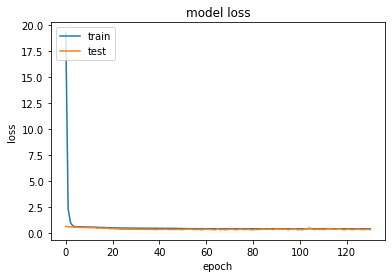

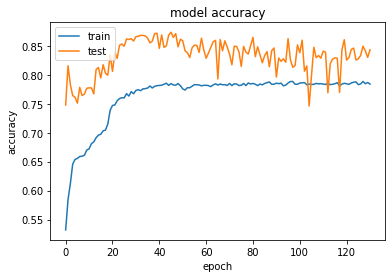

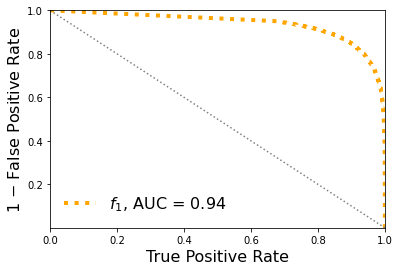

Classification score:


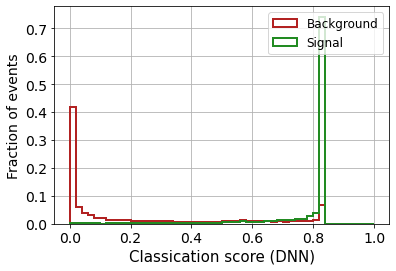


 ROC-AUC =  0.9379555013439186


In [35]:

# define the keras model
model = Sequential()
model.add(Dense(4, input_shape=(X_mon_train.shape[1],), activation='relu'))
model.add(Dropout(0.20))
# model.add(Dense(8, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

### CNN

In [32]:
# prepare the dataset
X_mon_train_cn = X_mon_train.reshape(X_mon_train.shape[0], X_mon_train.shape[1], 1)
X_mon_test_cn = X_mon_test.reshape(X_mon_test.shape[0], X_mon_test.shape[1], 1)
X_mon_val_cn = X_mon_val.reshape(X_mon_val.shape[0], X_mon_val.shape[1], 1)

Epoch 1/500
319/319 [==============================] - 1s 1ms/step - loss: 21.5861 - accuracy: 0.5368 - val_loss: 0.4792 - val_accuracy: 0.7972
Epoch 2/500
319/319 [==============================] - 0s 811us/step - loss: 0.4975 - accuracy: 0.7774 - val_loss: 0.4164 - val_accuracy: 0.8191
Epoch 3/500
319/319 [==============================] - 0s 812us/step - loss: 0.4586 - accuracy: 0.7993 - val_loss: 0.4019 - val_accuracy: 0.8215
Epoch 4/500
319/319 [==============================] - 0s 840us/step - loss: 0.4551 - accuracy: 0.7910 - val_loss: 0.3874 - val_accuracy: 0.8269
Epoch 5/500
319/319 [==============================] - 0s 814us/step - loss: 0.4341 - accuracy: 0.8088 - val_loss: 0.3868 - val_accuracy: 0.8211
Epoch 6/500
319/319 [==============================] - 0s 799us/step - loss: 0.4232 - accuracy: 0.8103 - val_loss: 0.3780 - val_accuracy: 0.8300
Epoch 7/500
319/319 [==============================] - 0s 797us/step - loss: 0.4205 - accuracy: 0.8114 - val_loss: 0.3687 - val_acc

319/319 [==============================] - 0s 797us/step - loss: 0.3168 - accuracy: 0.8685 - val_loss: 0.2724 - val_accuracy: 0.8913
Epoch 114/500
319/319 [==============================] - 0s 793us/step - loss: 0.3157 - accuracy: 0.8701 - val_loss: 0.2816 - val_accuracy: 0.8819
Epoch 115/500
319/319 [==============================] - 0s 804us/step - loss: 0.3138 - accuracy: 0.8692 - val_loss: 0.2712 - val_accuracy: 0.8856
Epoch 116/500
319/319 [==============================] - 0s 856us/step - loss: 0.3181 - accuracy: 0.8690 - val_loss: 0.2649 - val_accuracy: 0.8910
Epoch 117/500
319/319 [==============================] - 0s 833us/step - loss: 0.3216 - accuracy: 0.8676 - val_loss: 0.2657 - val_accuracy: 0.8919
Epoch 118/500
319/319 [==============================] - 0s 836us/step - loss: 0.3215 - accuracy: 0.8660 - val_loss: 0.2780 - val_accuracy: 0.8837
Epoch 119/500
319/319 [==============================] - 0s 804us/step - loss: 0.3182 - accuracy: 0.8685 - val_loss: 0.2665 - val_ac

Epoch 169/500
319/319 [==============================] - 0s 825us/step - loss: 0.3126 - accuracy: 0.8704 - val_loss: 0.2650 - val_accuracy: 0.8906
Epoch 170/500
319/319 [==============================] - 0s 816us/step - loss: 0.3171 - accuracy: 0.8695 - val_loss: 0.2615 - val_accuracy: 0.8926
Epoch 171/500
319/319 [==============================] - 0s 796us/step - loss: 0.3175 - accuracy: 0.8682 - val_loss: 0.2696 - val_accuracy: 0.8916
Epoch 172/500
319/319 [==============================] - 0s 813us/step - loss: 0.3165 - accuracy: 0.8659 - val_loss: 0.2832 - val_accuracy: 0.8799
Epoch 173/500
319/319 [==============================] - 0s 841us/step - loss: 0.3177 - accuracy: 0.8668 - val_loss: 0.2678 - val_accuracy: 0.8874
Epoch 174/500
319/319 [==============================] - 0s 812us/step - loss: 0.3182 - accuracy: 0.8681 - val_loss: 0.2647 - val_accuracy: 0.8923
Epoch 175/500
319/319 [==============================] - 0s 809us/step - loss: 0.3126 - accuracy: 0.8681 - val_loss: 0

Epoch 225/500
319/319 [==============================] - 0s 796us/step - loss: 0.3112 - accuracy: 0.8699 - val_loss: 0.2614 - val_accuracy: 0.8927
Epoch 226/500
319/319 [==============================] - 0s 798us/step - loss: 0.3095 - accuracy: 0.8701 - val_loss: 0.2649 - val_accuracy: 0.8926
Epoch 227/500
319/319 [==============================] - 0s 801us/step - loss: 0.3187 - accuracy: 0.8665 - val_loss: 0.2625 - val_accuracy: 0.8919
Epoch 228/500
319/319 [==============================] - 0s 791us/step - loss: 0.3134 - accuracy: 0.8695 - val_loss: 0.2651 - val_accuracy: 0.8920
Epoch 229/500
319/319 [==============================] - 0s 794us/step - loss: 0.3080 - accuracy: 0.8709 - val_loss: 0.2729 - val_accuracy: 0.8859
Epoch 230/500
319/319 [==============================] - 0s 795us/step - loss: 0.3116 - accuracy: 0.8707 - val_loss: 0.2661 - val_accuracy: 0.8930
Epoch 231/500
319/319 [==============================] - 0s 798us/step - loss: 0.3135 - accuracy: 0.8679 - val_loss: 0

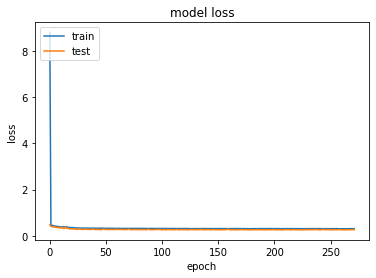

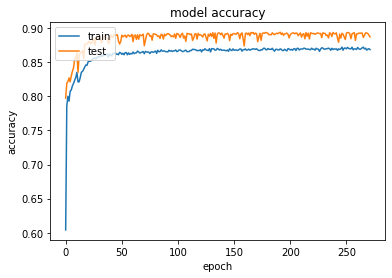

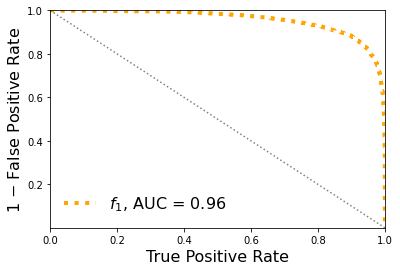

Classification score:


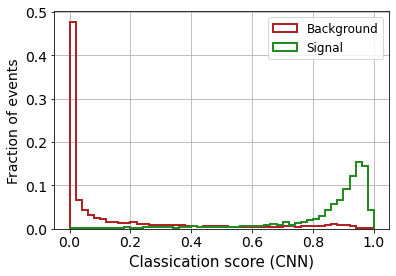


 ROC-AUC =  0.9559572286920114


In [33]:

# define the keras model
model = Sequential()
model.add(Conv1D(8, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

## 3. Keep 4 variables, pA_S1, pA_S2, ptop, pbot

In [36]:
remove_col = [1,2,3,4,5,6]

B_pbot = B_pbot
B_ptop = B_ptop
B_ppeakS1 = np.delete(B_ppeakS1, remove_col, axis=1)
B_ppeakS2 = np.delete(B_ppeakS2, remove_col, axis=1)

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot
S_ptop = S_ptop
S_ppeakS1 = np.delete(S_ppeakS1, remove_col, axis=1)
S_ppeakS2 = np.delete(S_ppeakS2, remove_col, axis=1)

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

B_pbot.shape:  (32015,)
B_ptop.shape:  (32015,)
B_ppeakS1.shape : (32015, 1)
B_ppeakS2.shape:  (32015, 1)
S_pbot.shape:  (32015,)
S_ptop.shape:  (32015,)
S_ppeakS1.shape : (32015, 1)
S_ppeakS2.shape:  (32015, 1)


In [37]:
# concatenate the data
X_mon_B = np.concatenate([B_ppeakS1, B_ppeakS2, np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(B_ptop,(len(B_ptop),1)) ],axis=1)
X_mon_S = np.concatenate([S_ppeakS1, S_ppeakS2, np.reshape(S_pbot,(len(S_pbot),1)), np.reshape(S_ptop,(len(S_ptop),1)) ],axis=1)

print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)

# del B_ppeakS1
# del B_ppeakS2
# del B_pbot
# del B_ptop

# del S_ppeakS1
# del S_ppeakS2
# del S_pbot
# del S_ptop

X_mon = np.concatenate([X_mon_B, X_mon_S])

# X_mon = np.concatenate([np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(S_pbot,(len(S_pbot),1))])

print('X_mon.shape: ', X_mon.shape)
# del X_mon_B
# del X_mon_S


# labels
y_mon = np.concatenate([np.zeros(NUM_DAT),np.ones(NUM_DAT)])


# divide into train-val and test data samples
test_ratio = 0.25
val_ratio = 0.15


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

del X_mon
del y_mon

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

del X_mon_aux
del y_mon_aux

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

X_mon_B.shape:  (32015, 4)
X_mon_S.shape:  (32015, 4)
X_mon.shape:  (64030, 4)

X_mon_train :  (40818, 4)
y_mon_train :  (40818,)
X_mon_val :  (7204, 4)
y_mon_val :  (7204,)
X_mon_test :  (16008, 4)
y_mon_test :  (16008,)



### XGBoost

[0]	validation_0-logloss:0.64378	validation_1-logloss:0.64318
[1]	validation_0-logloss:0.60361	validation_1-logloss:0.60259
[2]	validation_0-logloss:0.56995	validation_1-logloss:0.56859
[3]	validation_0-logloss:0.54138	validation_1-logloss:0.53984
[4]	validation_0-logloss:0.51734	validation_1-logloss:0.51563


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[5]	validation_0-logloss:0.49690	validation_1-logloss:0.49484
[6]	validation_0-logloss:0.47913	validation_1-logloss:0.47694
[7]	validation_0-logloss:0.46334	validation_1-logloss:0.46145
[8]	validation_0-logloss:0.44999	validation_1-logloss:0.44797
[9]	validation_0-logloss:0.43838	validation_1-logloss:0.43616
[10]	validation_0-logloss:0.42817	validation_1-logloss:0.42603
[11]	validation_0-logloss:0.41897	validation_1-logloss:0.41707
[12]	validation_0-logloss:0.41109	validation_1-logloss:0.40937
[13]	validation_0-logloss:0.40419	validation_1-logloss:0.40264
[14]	validation_0-logloss:0.39769	validation_1-logloss:0.39650
[15]	validation_0-logloss:0.39213	validation_1-logloss:0.39128
[16]	validation_0-logloss:0.38736	validation_1-logloss:0.38650
[17]	validation_0-logloss:0.38289	validation_1-logloss:0.38219
[18]	validation_0-logloss:0.37897	validation_1-logloss:0.37842
[19]	validation_0-logloss:0.37506	validation_1-logloss:0.37491
[20]	validation_0-logloss:0.37176	validation_1-logloss:0.371

[135]	validation_0-logloss:0.29213	validation_1-logloss:0.32121
[136]	validation_0-logloss:0.29202	validation_1-logloss:0.32128
[137]	validation_0-logloss:0.29182	validation_1-logloss:0.32128
[138]	validation_0-logloss:0.29178	validation_1-logloss:0.32126
[139]	validation_0-logloss:0.29141	validation_1-logloss:0.32124
[140]	validation_0-logloss:0.29119	validation_1-logloss:0.32122
[141]	validation_0-logloss:0.29112	validation_1-logloss:0.32116
[142]	validation_0-logloss:0.29095	validation_1-logloss:0.32115
[143]	validation_0-logloss:0.29075	validation_1-logloss:0.32111
[144]	validation_0-logloss:0.29062	validation_1-logloss:0.32110
[145]	validation_0-logloss:0.29052	validation_1-logloss:0.32107
[146]	validation_0-logloss:0.29035	validation_1-logloss:0.32106
[147]	validation_0-logloss:0.29001	validation_1-logloss:0.32094
[148]	validation_0-logloss:0.28985	validation_1-logloss:0.32089
[149]	validation_0-logloss:0.28976	validation_1-logloss:0.32094
[150]	validation_0-logloss:0.28967	valid

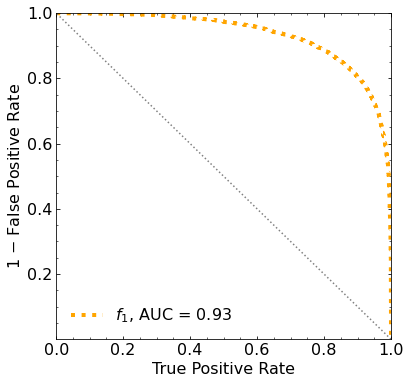

Classification score:


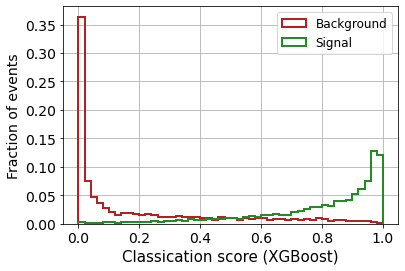


 ROC-AUC =  0.9323629515913405


In [38]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

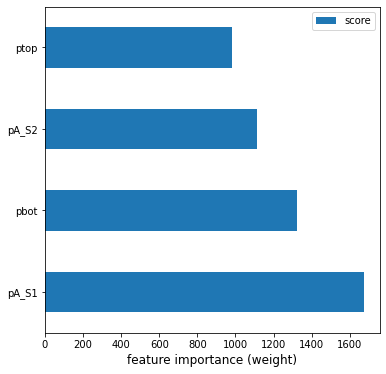

In [39]:
feature_important = classifier.get_booster().get_score(importance_type='weight')
# keys = list(feature_important.keys())
keys = ['pA_S1','pA_S2','pbot', 'ptop']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 40 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

### DNN

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 4)                 20        
_________________________________________________________________
dropout_18 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_27 (Dense)             (None, 16)                80        
_________________________________________________________________
dropout_19 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 4)                 68        
_________________________________________________________________
dropout_20 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                

319/319 [==============================] - 0s 598us/step - loss: 0.4835 - accuracy: 0.7532 - val_loss: 0.4142 - val_accuracy: 0.8159
Epoch 105/500
319/319 [==============================] - 0s 529us/step - loss: 0.4831 - accuracy: 0.7506 - val_loss: 0.4203 - val_accuracy: 0.8101
Epoch 106/500
319/319 [==============================] - 0s 510us/step - loss: 0.4812 - accuracy: 0.7523 - val_loss: 0.3993 - val_accuracy: 0.8263
Epoch 107/500
319/319 [==============================] - 0s 521us/step - loss: 0.4813 - accuracy: 0.7528 - val_loss: 0.3953 - val_accuracy: 0.8270
Epoch 108/500
319/319 [==============================] - 0s 524us/step - loss: 0.4793 - accuracy: 0.7555 - val_loss: 0.4064 - val_accuracy: 0.8212
Epoch 109/500
319/319 [==============================] - 0s 506us/step - loss: 0.4774 - accuracy: 0.7544 - val_loss: 0.3958 - val_accuracy: 0.8265
Epoch 110/500
319/319 [==============================] - 0s 499us/step - loss: 0.4820 - accuracy: 0.7514 - val_loss: 0.3810 - val_ac

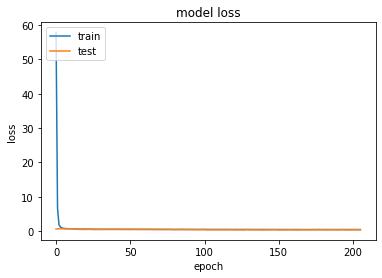

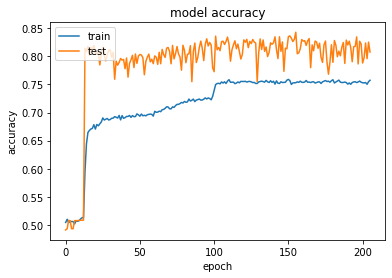

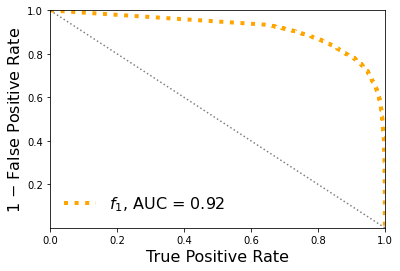

Classification score:


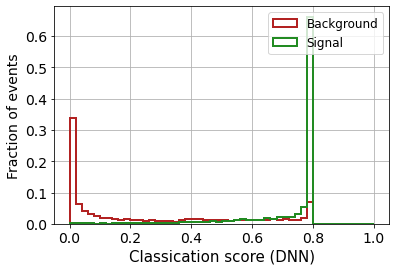


 ROC-AUC =  0.9150950513664157


In [43]:

# define the keras model
model = Sequential()
model.add(Dense(4, input_shape=(X_mon_train.shape[1],), activation='relu'))
model.add(Dropout(0.20))
# model.add(Dense(8, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

### CNN

In [41]:
# prepare the dataset
X_mon_train_cn = X_mon_train.reshape(X_mon_train.shape[0], X_mon_train.shape[1], 1)
X_mon_test_cn = X_mon_test.reshape(X_mon_test.shape[0], X_mon_test.shape[1], 1)
X_mon_val_cn = X_mon_val.reshape(X_mon_val.shape[0], X_mon_val.shape[1], 1)

Epoch 1/500
319/319 [==============================] - 1s 1ms/step - loss: 462.7204 - accuracy: 0.4998 - val_loss: 1.0050 - val_accuracy: 0.4921
Epoch 2/500
319/319 [==============================] - 0s 564us/step - loss: 0.8635 - accuracy: 0.5005 - val_loss: 0.9944 - val_accuracy: 0.4925
Epoch 3/500
319/319 [==============================] - 0s 568us/step - loss: 0.8398 - accuracy: 0.5027 - val_loss: 0.9829 - val_accuracy: 0.4925
Epoch 4/500
319/319 [==============================] - 0s 565us/step - loss: 0.8332 - accuracy: 0.4987 - val_loss: 0.9682 - val_accuracy: 0.4925
Epoch 5/500
319/319 [==============================] - 0s 566us/step - loss: 0.7881 - accuracy: 0.5011 - val_loss: 0.9499 - val_accuracy: 0.4925
Epoch 6/500
319/319 [==============================] - 0s 551us/step - loss: 0.8782 - accuracy: 0.5033 - val_loss: 0.9253 - val_accuracy: 0.4925
Epoch 7/500
319/319 [==============================] - 0s 551us/step - loss: 0.8892 - accuracy: 0.5034 - val_loss: 0.8977 - val_ac

319/319 [==============================] - 0s 576us/step - loss: 0.4828 - accuracy: 0.7744 - val_loss: 0.4070 - val_accuracy: 0.8443
Epoch 114/500
319/319 [==============================] - 0s 573us/step - loss: 0.4868 - accuracy: 0.7702 - val_loss: 0.4041 - val_accuracy: 0.8437
Epoch 115/500
319/319 [==============================] - 0s 560us/step - loss: 0.4876 - accuracy: 0.7715 - val_loss: 0.4186 - val_accuracy: 0.8348
Epoch 116/500
319/319 [==============================] - 0s 566us/step - loss: 0.4884 - accuracy: 0.7719 - val_loss: 0.3953 - val_accuracy: 0.8498
Epoch 117/500
319/319 [==============================] - 0s 564us/step - loss: 0.4892 - accuracy: 0.7691 - val_loss: 0.3945 - val_accuracy: 0.8498
Epoch 118/500
319/319 [==============================] - 0s 544us/step - loss: 0.4818 - accuracy: 0.7759 - val_loss: 0.5429 - val_accuracy: 0.7360
Epoch 119/500
319/319 [==============================] - 0s 560us/step - loss: 0.4921 - accuracy: 0.7689 - val_loss: 0.3957 - val_ac

Epoch 169/500
319/319 [==============================] - 0s 593us/step - loss: 0.4866 - accuracy: 0.7712 - val_loss: 0.4057 - val_accuracy: 0.8409
Epoch 170/500
319/319 [==============================] - 0s 562us/step - loss: 0.4799 - accuracy: 0.7775 - val_loss: 0.4058 - val_accuracy: 0.8397
Epoch 171/500
319/319 [==============================] - 0s 552us/step - loss: 0.4914 - accuracy: 0.7675 - val_loss: 0.3978 - val_accuracy: 0.8472
Epoch 172/500
319/319 [==============================] - 0s 549us/step - loss: 0.4874 - accuracy: 0.7710 - val_loss: 0.3994 - val_accuracy: 0.8466
Epoch 173/500
319/319 [==============================] - 0s 549us/step - loss: 0.4835 - accuracy: 0.7737 - val_loss: 0.3985 - val_accuracy: 0.8448
Epoch 174/500
319/319 [==============================] - 0s 557us/step - loss: 0.4812 - accuracy: 0.7727 - val_loss: 0.4167 - val_accuracy: 0.8361
Epoch 175/500
319/319 [==============================] - 0s 550us/step - loss: 0.4864 - accuracy: 0.7695 - val_loss: 0

Epoch 225/500
319/319 [==============================] - 0s 563us/step - loss: 0.4871 - accuracy: 0.7676 - val_loss: 0.4027 - val_accuracy: 0.8433
Epoch 226/500
319/319 [==============================] - 0s 559us/step - loss: 0.4855 - accuracy: 0.7689 - val_loss: 0.3898 - val_accuracy: 0.8509
Epoch 227/500
319/319 [==============================] - 0s 569us/step - loss: 0.4807 - accuracy: 0.7732 - val_loss: 0.4089 - val_accuracy: 0.8384
Epoch 228/500
319/319 [==============================] - 0s 552us/step - loss: 0.4811 - accuracy: 0.7746 - val_loss: 0.3883 - val_accuracy: 0.8499
Epoch 229/500
319/319 [==============================] - 0s 552us/step - loss: 0.4825 - accuracy: 0.7748 - val_loss: 0.3892 - val_accuracy: 0.8501
Epoch 230/500
319/319 [==============================] - 0s 556us/step - loss: 0.4947 - accuracy: 0.7672 - val_loss: 0.3988 - val_accuracy: 0.8470
Epoch 231/500
319/319 [==============================] - 0s 550us/step - loss: 0.4829 - accuracy: 0.7712 - val_loss: 0

Epoch 281/500
319/319 [==============================] - 0s 554us/step - loss: 0.4832 - accuracy: 0.7719 - val_loss: 0.3890 - val_accuracy: 0.8523
Epoch 282/500
319/319 [==============================] - 0s 567us/step - loss: 0.4868 - accuracy: 0.7689 - val_loss: 0.3868 - val_accuracy: 0.8499
Epoch 283/500
319/319 [==============================] - 0s 548us/step - loss: 0.4792 - accuracy: 0.7724 - val_loss: 0.3885 - val_accuracy: 0.8523
Epoch 284/500
319/319 [==============================] - 0s 552us/step - loss: 0.4828 - accuracy: 0.7708 - val_loss: 0.3910 - val_accuracy: 0.8487
Epoch 285/500
319/319 [==============================] - 0s 557us/step - loss: 0.4754 - accuracy: 0.7774 - val_loss: 0.4114 - val_accuracy: 0.8365
Epoch 286/500
319/319 [==============================] - 0s 559us/step - loss: 0.4802 - accuracy: 0.7732 - val_loss: 0.4156 - val_accuracy: 0.8345
Epoch 287/500
319/319 [==============================] - 0s 572us/step - loss: 0.4825 - accuracy: 0.7706 - val_loss: 0

Epoch 337/500
319/319 [==============================] - 0s 565us/step - loss: 0.4745 - accuracy: 0.7766 - val_loss: 0.3850 - val_accuracy: 0.8512
Epoch 338/500
319/319 [==============================] - 0s 560us/step - loss: 0.4754 - accuracy: 0.7758 - val_loss: 0.3874 - val_accuracy: 0.8516
Epoch 339/500
319/319 [==============================] - 0s 565us/step - loss: 0.4749 - accuracy: 0.7763 - val_loss: 0.3969 - val_accuracy: 0.8447
Epoch 340/500
319/319 [==============================] - 0s 546us/step - loss: 0.4817 - accuracy: 0.7706 - val_loss: 0.3872 - val_accuracy: 0.8523
Epoch 341/500
319/319 [==============================] - 0s 547us/step - loss: 0.4781 - accuracy: 0.7743 - val_loss: 0.3857 - val_accuracy: 0.8520
Epoch 342/500
319/319 [==============================] - 0s 540us/step - loss: 0.4812 - accuracy: 0.7711 - val_loss: 0.3963 - val_accuracy: 0.8458
Epoch 343/500
319/319 [==============================] - 0s 548us/step - loss: 0.4755 - accuracy: 0.7760 - val_loss: 0

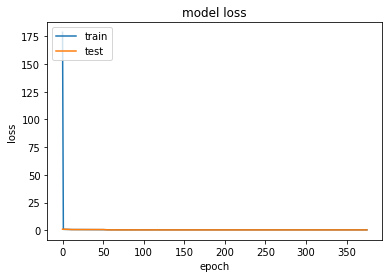

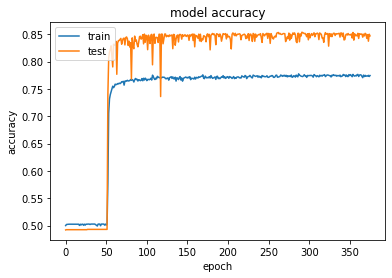

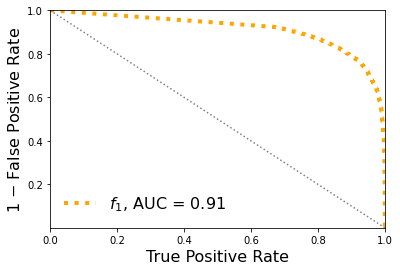

Classification score:


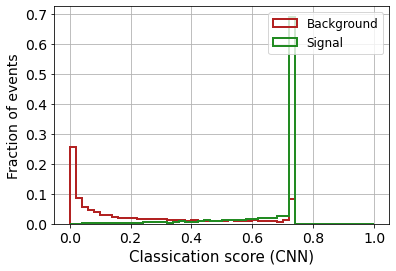


 ROC-AUC =  0.9129459193184795


In [46]:

# define the keras model
model = Sequential()
model.add(Conv1D(8, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Flatten())
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

## 4. Keep only diffT

In [47]:
# concatenate the data
# X_mon_B = np.concatenate([B_ppeakS1, B_ppeakS2, np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(B_ptop,(len(B_ptop),1)), np.reshape(B_pdiffT,(len(B_pdiffT),1)) ],axis=1)
# X_mon_S = np.concatenate([S_ppeakS1, S_ppeakS2, np.reshape(S_pbot,(len(S_pbot),1)), np.reshape(S_ptop,(len(S_ptop),1)), np.reshape(S_pdiffT,(len(S_pdiffT),1)) ],axis=1)

X_mon_B = np.reshape(B_pdiffT,(len(B_pdiffT),1))
X_mon_S = np.reshape(S_pdiffT,(len(S_pdiffT),1))
print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)

# del B_ppeakS1
# del B_ppeakS2
# del B_pbot
# del B_ptop

# del S_ppeakS1
# del S_ppeakS2
# del S_pbot
# del S_ptop

X_mon = np.concatenate([X_mon_B, X_mon_S])

# X_mon = np.concatenate([np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(S_pbot,(len(S_pbot),1))])

print('X_mon.shape: ', X_mon.shape)
# del X_mon_B
# del X_mon_S


# labels
y_mon = np.concatenate([np.zeros(NUM_DAT),np.ones(NUM_DAT)])


# divide into train-val and test data samples
test_ratio = 0.25
val_ratio = 0.15


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

del X_mon
del y_mon

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

del X_mon_aux
del y_mon_aux

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

X_mon_B.shape:  (32015, 1)
X_mon_S.shape:  (32015, 1)
X_mon.shape:  (64030, 1)

X_mon_train :  (40818, 1)
y_mon_train :  (40818,)
X_mon_val :  (7204, 1)
y_mon_val :  (7204,)
X_mon_test :  (16008, 1)
y_mon_test :  (16008,)



### XGBoost

[0]	validation_0-logloss:0.69270	validation_1-logloss:0.69306
[1]	validation_0-logloss:0.69235	validation_1-logloss:0.69290
[2]	validation_0-logloss:0.69201	validation_1-logloss:0.69291


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3]	validation_0-logloss:0.69176	validation_1-logloss:0.69288
[4]	validation_0-logloss:0.69151	validation_1-logloss:0.69290
[5]	validation_0-logloss:0.69128	validation_1-logloss:0.69297
[6]	validation_0-logloss:0.69105	validation_1-logloss:0.69296
[7]	validation_0-logloss:0.69087	validation_1-logloss:0.69302
[8]	validation_0-logloss:0.69071	validation_1-logloss:0.69307
[9]	validation_0-logloss:0.69054	validation_1-logloss:0.69312
[10]	validation_0-logloss:0.69036	validation_1-logloss:0.69319
[11]	validation_0-logloss:0.69015	validation_1-logloss:0.69326
[12]	validation_0-logloss:0.68996	validation_1-logloss:0.69332
[13]	validation_0-logloss:0.68983	validation_1-logloss:0.69339
[14]	validation_0-logloss:0.68967	validation_1-logloss:0.69347
[15]	validation_0-logloss:0.68948	validation_1-logloss:0.69353
[16]	validation_0-logloss:0.68936	validation_1-logloss:0.69356
[17]	validation_0-logloss:0.68924	validation_1-logloss:0.69347
[18]	validation_0-logloss:0.68912	validation_1-logloss:0.69350

[133]	validation_0-logloss:0.67799	validation_1-logloss:0.69670
[134]	validation_0-logloss:0.67794	validation_1-logloss:0.69673
[135]	validation_0-logloss:0.67787	validation_1-logloss:0.69678
[136]	validation_0-logloss:0.67779	validation_1-logloss:0.69686
[137]	validation_0-logloss:0.67768	validation_1-logloss:0.69685
[138]	validation_0-logloss:0.67762	validation_1-logloss:0.69682
[139]	validation_0-logloss:0.67752	validation_1-logloss:0.69675
[140]	validation_0-logloss:0.67735	validation_1-logloss:0.69677
[141]	validation_0-logloss:0.67725	validation_1-logloss:0.69672
[142]	validation_0-logloss:0.67717	validation_1-logloss:0.69674
[143]	validation_0-logloss:0.67705	validation_1-logloss:0.69675
[144]	validation_0-logloss:0.67693	validation_1-logloss:0.69674
[145]	validation_0-logloss:0.67687	validation_1-logloss:0.69672
[146]	validation_0-logloss:0.67672	validation_1-logloss:0.69679
[147]	validation_0-logloss:0.67666	validation_1-logloss:0.69683
[148]	validation_0-logloss:0.67647	valid

[262]	validation_0-logloss:0.66931	validation_1-logloss:0.69951
[263]	validation_0-logloss:0.66931	validation_1-logloss:0.69952
[264]	validation_0-logloss:0.66929	validation_1-logloss:0.69953
[265]	validation_0-logloss:0.66926	validation_1-logloss:0.69958
[266]	validation_0-logloss:0.66916	validation_1-logloss:0.69959
[267]	validation_0-logloss:0.66908	validation_1-logloss:0.69955
[268]	validation_0-logloss:0.66907	validation_1-logloss:0.69960
[269]	validation_0-logloss:0.66899	validation_1-logloss:0.69964
[270]	validation_0-logloss:0.66897	validation_1-logloss:0.69963
[271]	validation_0-logloss:0.66886	validation_1-logloss:0.69970
[272]	validation_0-logloss:0.66877	validation_1-logloss:0.69972
[273]	validation_0-logloss:0.66867	validation_1-logloss:0.69974
[274]	validation_0-logloss:0.66856	validation_1-logloss:0.69977
[275]	validation_0-logloss:0.66850	validation_1-logloss:0.69979
[276]	validation_0-logloss:0.66841	validation_1-logloss:0.69979
[277]	validation_0-logloss:0.66824	valid

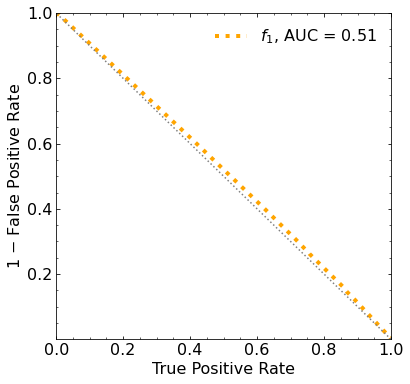

Classification score:


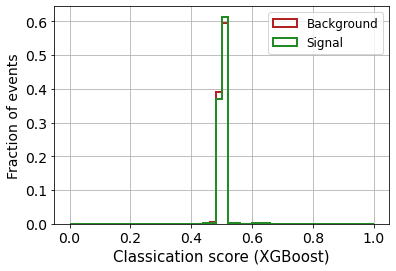


 ROC-AUC =  0.5149919340521245


In [48]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=300,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

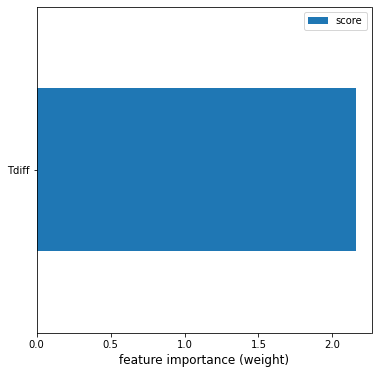

In [49]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
# keys = list(feature_important.keys())
keys = ['Tdiff']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 40 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

### DNN

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 4)                 8         
_________________________________________________________________
dropout_24 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_37 (Dense)             (None, 16)                80        
_________________________________________________________________
dropout_25 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 4)                 68        
_________________________________________________________________
dropout_26 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)               

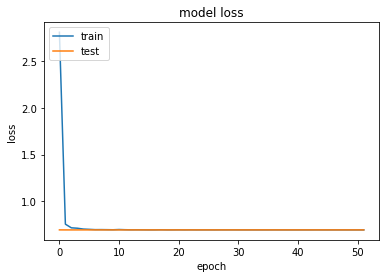

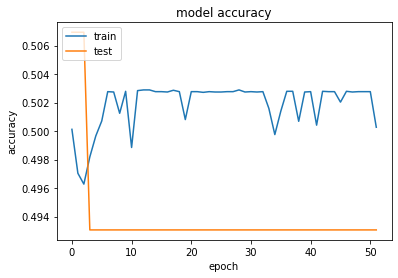

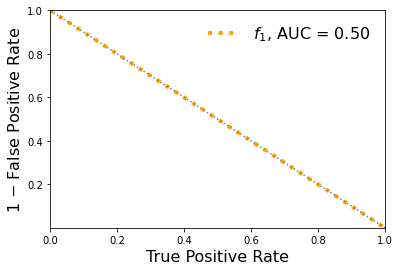

Classification score:


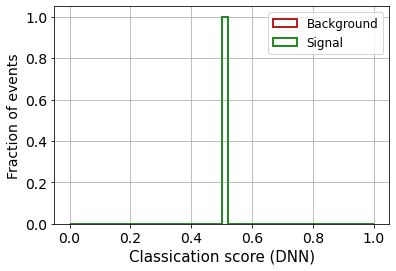


 ROC-AUC =  0.5


In [50]:

# define the keras model
model = Sequential()
model.add(Dense(4, input_shape=(X_mon_train.shape[1],), activation='relu'))
model.add(Dropout(0.20))
# model.add(Dense(8, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

### CNN

In [51]:
# prepare the dataset
X_mon_train_cn = X_mon_train.reshape(X_mon_train.shape[0], X_mon_train.shape[1], 1)
X_mon_test_cn = X_mon_test.reshape(X_mon_test.shape[0], X_mon_test.shape[1], 1)
X_mon_val_cn = X_mon_val.reshape(X_mon_val.shape[0], X_mon_val.shape[1], 1)

In [52]:

# define the keras model
model = Sequential()
model.add(Conv1D(8, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Flatten())
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

ValueError: Negative dimension size caused by subtracting 2 from 1 for '{{node conv1d_6/conv1d}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](conv1d_6/conv1d/ExpandDims, conv1d_6/conv1d/ExpandDims_1)' with input shapes: [?,1,1,1], [1,2,1,8].

## 5. Keep the 6 most important features (re-load the variables first)

##### Remove some columns or features (if you want)

In [62]:
# features = ['pT0','pA','pH','pHT','pL','pL90','pRMSW','pHTL']
remove_col_S1 = [0,2,3,4,5,7]
remove_col_S2 = [0,2,3,4,5,6,7]

B_pbot = B_pbot
B_ptop = B_ptop
B_ppeakS1 = np.delete(B_ppeakS1, remove_col_S1, axis=1)
B_ppeakS2 = np.delete(B_ppeakS2, remove_col_S2, axis=1)

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot
S_ptop = S_ptop
S_ppeakS1 = np.delete(S_ppeakS1, remove_col_S1, axis=1)
S_ppeakS2 = np.delete(S_ppeakS2, remove_col_S2, axis=1)

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

B_pbot.shape:  (32015,)
B_ptop.shape:  (32015,)
B_ppeakS1.shape : (32015, 2)
B_ppeakS2.shape:  (32015, 1)
S_pbot.shape:  (32015,)
S_ptop.shape:  (32015,)
S_ppeakS1.shape : (32015, 2)
S_ppeakS2.shape:  (32015, 1)


In [63]:
# concatenate the data
X_mon_B = np.concatenate([B_ppeakS1, B_ppeakS2, np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(B_ptop,(len(B_ptop),1)), np.reshape(B_pdiffT,(len(B_pdiffT),1)) ],axis=1)
X_mon_S = np.concatenate([S_ppeakS1, S_ppeakS2, np.reshape(S_pbot,(len(S_pbot),1)), np.reshape(S_ptop,(len(S_ptop),1)), np.reshape(S_pdiffT,(len(S_pdiffT),1)) ],axis=1)

# X_mon_B = np.reshape(B_pdiffT,(len(B_pdiffT),1))
# X_mon_S = np.reshape(S_pdiffT,(len(S_pdiffT),1))
print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)

# del B_ppeakS1
# del B_ppeakS2
# del B_pbot
# del B_ptop

# del S_ppeakS1
# del S_ppeakS2
# del S_pbot
# del S_ptop

X_mon = np.concatenate([X_mon_B, X_mon_S])

# X_mon = np.concatenate([np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(S_pbot,(len(S_pbot),1))])

print('X_mon.shape: ', X_mon.shape)
# del X_mon_B
# del X_mon_S


# labels
y_mon = np.concatenate([np.zeros(NUM_DAT),np.ones(NUM_DAT)])


# divide into train-val and test data samples
test_ratio = 0.25
val_ratio = 0.15


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

del X_mon
del y_mon

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

del X_mon_aux
del y_mon_aux

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

X_mon_B.shape:  (32015, 6)
X_mon_S.shape:  (32015, 6)
X_mon.shape:  (64030, 6)

X_mon_train :  (40818, 6)
y_mon_train :  (40818,)
X_mon_val :  (7204, 6)
y_mon_val :  (7204,)
X_mon_test :  (16008, 6)
y_mon_test :  (16008,)



### XGBoost

[0]	validation_0-logloss:0.63109	validation_1-logloss:0.63154
[1]	validation_0-logloss:0.58035	validation_1-logloss:0.58142
[2]	validation_0-logloss:0.53736	validation_1-logloss:0.53833
[3]	validation_0-logloss:0.50129	validation_1-logloss:0.50216


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-logloss:0.46889	validation_1-logloss:0.47053
[5]	validation_0-logloss:0.44185	validation_1-logloss:0.44348
[6]	validation_0-logloss:0.41628	validation_1-logloss:0.41826
[7]	validation_0-logloss:0.39391	validation_1-logloss:0.39580
[8]	validation_0-logloss:0.37441	validation_1-logloss:0.37651
[9]	validation_0-logloss:0.35724	validation_1-logloss:0.35962
[10]	validation_0-logloss:0.34153	validation_1-logloss:0.34444
[11]	validation_0-logloss:0.32704	validation_1-logloss:0.33006
[12]	validation_0-logloss:0.31490	validation_1-logloss:0.31819
[13]	validation_0-logloss:0.30290	validation_1-logloss:0.30688
[14]	validation_0-logloss:0.29278	validation_1-logloss:0.29734
[15]	validation_0-logloss:0.28289	validation_1-logloss:0.28789
[16]	validation_0-logloss:0.27371	validation_1-logloss:0.27918
[17]	validation_0-logloss:0.26582	validation_1-logloss:0.27150
[18]	validation_0-logloss:0.25889	validation_1-logloss:0.26511
[19]	validation_0-logloss:0.25215	validation_1-logloss:0.2584

[134]	validation_0-logloss:0.14666	validation_1-logloss:0.17866
[135]	validation_0-logloss:0.14657	validation_1-logloss:0.17863
[136]	validation_0-logloss:0.14638	validation_1-logloss:0.17865
[137]	validation_0-logloss:0.14619	validation_1-logloss:0.17859
[138]	validation_0-logloss:0.14615	validation_1-logloss:0.17858
[139]	validation_0-logloss:0.14597	validation_1-logloss:0.17860
[140]	validation_0-logloss:0.14588	validation_1-logloss:0.17864
[141]	validation_0-logloss:0.14560	validation_1-logloss:0.17860
[142]	validation_0-logloss:0.14547	validation_1-logloss:0.17864
[143]	validation_0-logloss:0.14533	validation_1-logloss:0.17864
[144]	validation_0-logloss:0.14513	validation_1-logloss:0.17861
[145]	validation_0-logloss:0.14499	validation_1-logloss:0.17863
[146]	validation_0-logloss:0.14489	validation_1-logloss:0.17863
[147]	validation_0-logloss:0.14475	validation_1-logloss:0.17855
[148]	validation_0-logloss:0.14460	validation_1-logloss:0.17846
[149]	validation_0-logloss:0.14447	valid

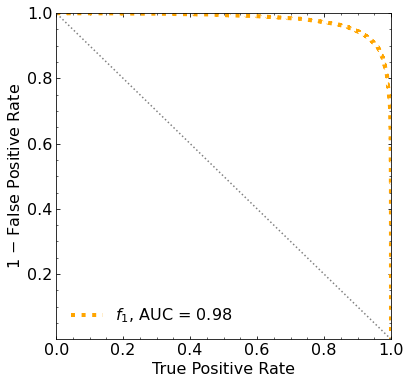

Classification score:


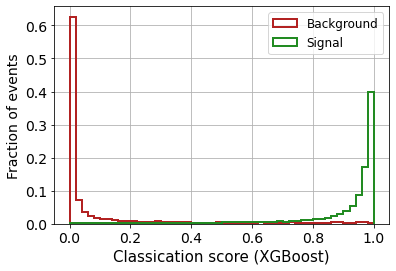


 ROC-AUC =  0.9794434977545365


In [64]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

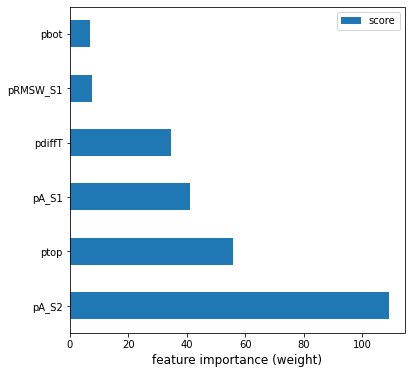

In [65]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
# keys = list(feature_important.keys())
keys = ['pA_S1','pRMSW_S1', 'pA_S2','pbot', 'ptop', 'pdiffT']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 40 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

### DNN

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 4)                 28        
_________________________________________________________________
dropout_34 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_51 (Dense)             (None, 16)                80        
_________________________________________________________________
dropout_35 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 4)                 68        
_________________________________________________________________
dropout_36 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_53 (Dense)             (None, 1)               

319/319 [==============================] - 0s 585us/step - loss: 0.3872 - accuracy: 0.8048 - val_loss: 0.4994 - val_accuracy: 0.6953
Epoch 105/500
319/319 [==============================] - 0s 595us/step - loss: 0.3828 - accuracy: 0.8066 - val_loss: 0.4654 - val_accuracy: 0.7496
Epoch 106/500
319/319 [==============================] - 0s 589us/step - loss: 0.3790 - accuracy: 0.8062 - val_loss: 0.4424 - val_accuracy: 0.7561
Epoch 107/500
319/319 [==============================] - 0s 612us/step - loss: 0.3865 - accuracy: 0.8064 - val_loss: 0.4539 - val_accuracy: 0.7497
Epoch 108/500
319/319 [==============================] - 0s 610us/step - loss: 0.3874 - accuracy: 0.8028 - val_loss: 0.4249 - val_accuracy: 0.8009
Epoch 109/500
319/319 [==============================] - 0s 607us/step - loss: 0.3816 - accuracy: 0.8073 - val_loss: 0.5183 - val_accuracy: 0.7217
Epoch 110/500
319/319 [==============================] - 0s 596us/step - loss: 0.3799 - accuracy: 0.8073 - val_loss: 0.4934 - val_ac

Epoch 160/500
319/319 [==============================] - 0s 595us/step - loss: 0.3764 - accuracy: 0.8081 - val_loss: 0.4202 - val_accuracy: 0.7959
Epoch 161/500
319/319 [==============================] - 0s 584us/step - loss: 0.3842 - accuracy: 0.8061 - val_loss: 0.4465 - val_accuracy: 0.7776
Epoch 162/500
319/319 [==============================] - 0s 587us/step - loss: 0.3725 - accuracy: 0.8100 - val_loss: 0.4565 - val_accuracy: 0.7657
Epoch 163/500
319/319 [==============================] - 0s 595us/step - loss: 0.3801 - accuracy: 0.8082 - val_loss: 0.3885 - val_accuracy: 0.8318
Epoch 164/500
319/319 [==============================] - 0s 590us/step - loss: 0.3792 - accuracy: 0.8068 - val_loss: 0.4224 - val_accuracy: 0.7901
Epoch 165/500
319/319 [==============================] - 0s 595us/step - loss: 0.3782 - accuracy: 0.8060 - val_loss: 0.4023 - val_accuracy: 0.8209
Epoch 166/500
319/319 [==============================] - 0s 603us/step - loss: 0.3767 - accuracy: 0.8109 - val_loss: 0

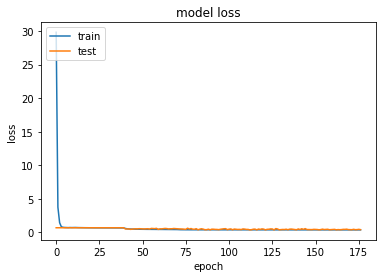

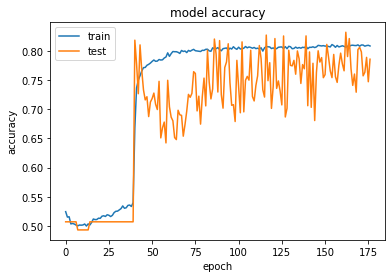

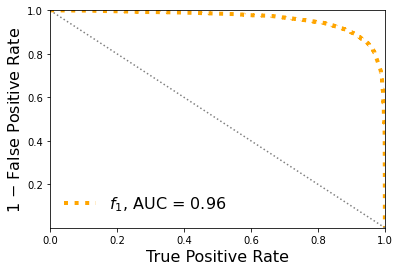

Classification score:


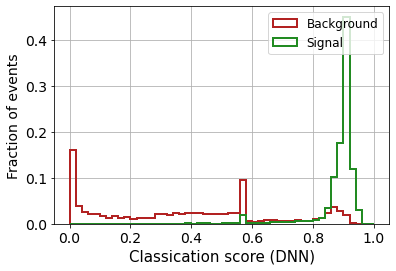


 ROC-AUC =  0.9621427455399777


In [70]:

# define the keras model
model = Sequential()
model.add(Dense(4, input_shape=(X_mon_train.shape[1],), activation='relu'))
model.add(Dropout(0.20))
# model.add(Dense(8, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

### CNN

In [67]:
# prepare the dataset
X_mon_train_cn = X_mon_train.reshape(X_mon_train.shape[0], X_mon_train.shape[1], 1)
X_mon_test_cn = X_mon_test.reshape(X_mon_test.shape[0], X_mon_test.shape[1], 1)
X_mon_val_cn = X_mon_val.reshape(X_mon_val.shape[0], X_mon_val.shape[1], 1)

Epoch 1/500
319/319 [==============================] - 1s 1ms/step - loss: 37.0348 - accuracy: 0.4939 - val_loss: 0.6023 - val_accuracy: 0.6787
Epoch 2/500
319/319 [==============================] - 0s 625us/step - loss: 0.6321 - accuracy: 0.6505 - val_loss: 0.5640 - val_accuracy: 0.7393
Epoch 3/500
319/319 [==============================] - 0s 614us/step - loss: 0.6020 - accuracy: 0.6752 - val_loss: 0.5395 - val_accuracy: 0.7581
Epoch 4/500
319/319 [==============================] - 0s 600us/step - loss: 0.5920 - accuracy: 0.6877 - val_loss: 0.5197 - val_accuracy: 0.7725
Epoch 5/500
319/319 [==============================] - 0s 621us/step - loss: 0.5856 - accuracy: 0.6931 - val_loss: 0.5105 - val_accuracy: 0.7711
Epoch 6/500
319/319 [==============================] - 0s 607us/step - loss: 0.5686 - accuracy: 0.7114 - val_loss: 0.4618 - val_accuracy: 0.8282
Epoch 7/500
319/319 [==============================] - 0s 593us/step - loss: 0.5369 - accuracy: 0.7409 - val_loss: 0.4643 - val_acc

319/319 [==============================] - 0s 606us/step - loss: 0.4001 - accuracy: 0.8298 - val_loss: 0.2847 - val_accuracy: 0.9084
Epoch 114/500
319/319 [==============================] - 0s 597us/step - loss: 0.3966 - accuracy: 0.8307 - val_loss: 0.2703 - val_accuracy: 0.9203
Epoch 115/500
319/319 [==============================] - 0s 590us/step - loss: 0.3981 - accuracy: 0.8326 - val_loss: 0.2782 - val_accuracy: 0.9185
Epoch 116/500
319/319 [==============================] - 0s 593us/step - loss: 0.4063 - accuracy: 0.8274 - val_loss: 0.2897 - val_accuracy: 0.9044
Epoch 117/500
319/319 [==============================] - 0s 611us/step - loss: 0.3980 - accuracy: 0.8303 - val_loss: 0.2697 - val_accuracy: 0.9216
Epoch 118/500
319/319 [==============================] - 0s 597us/step - loss: 0.3942 - accuracy: 0.8343 - val_loss: 0.2729 - val_accuracy: 0.9198
Epoch 119/500
319/319 [==============================] - 0s 598us/step - loss: 0.3980 - accuracy: 0.8310 - val_loss: 0.2661 - val_ac

Epoch 169/500
319/319 [==============================] - 0s 596us/step - loss: 0.3945 - accuracy: 0.8323 - val_loss: 0.2711 - val_accuracy: 0.9153
Epoch 170/500
319/319 [==============================] - 0s 594us/step - loss: 0.3985 - accuracy: 0.8306 - val_loss: 0.2744 - val_accuracy: 0.9187
Epoch 171/500
319/319 [==============================] - 0s 595us/step - loss: 0.3943 - accuracy: 0.8326 - val_loss: 0.2741 - val_accuracy: 0.9141
Epoch 172/500
319/319 [==============================] - 0s 608us/step - loss: 0.4004 - accuracy: 0.8299 - val_loss: 0.2708 - val_accuracy: 0.9202
Epoch 173/500
319/319 [==============================] - 0s 607us/step - loss: 0.4040 - accuracy: 0.8266 - val_loss: 0.2640 - val_accuracy: 0.9234
Epoch 174/500
319/319 [==============================] - 0s 592us/step - loss: 0.4027 - accuracy: 0.8280 - val_loss: 0.2639 - val_accuracy: 0.9228
Epoch 175/500
319/319 [==============================] - 0s 618us/step - loss: 0.3957 - accuracy: 0.8345 - val_loss: 0

Epoch 225/500
319/319 [==============================] - 0s 602us/step - loss: 0.3929 - accuracy: 0.8332 - val_loss: 0.2685 - val_accuracy: 0.9206
Epoch 226/500
319/319 [==============================] - 0s 606us/step - loss: 0.3895 - accuracy: 0.8350 - val_loss: 0.2720 - val_accuracy: 0.9144
Epoch 227/500
319/319 [==============================] - 0s 603us/step - loss: 0.3911 - accuracy: 0.8329 - val_loss: 0.2900 - val_accuracy: 0.9102
Epoch 228/500
319/319 [==============================] - 0s 594us/step - loss: 0.3946 - accuracy: 0.8316 - val_loss: 0.2828 - val_accuracy: 0.9094
Epoch 229/500
319/319 [==============================] - 0s 603us/step - loss: 0.3943 - accuracy: 0.8323 - val_loss: 0.2934 - val_accuracy: 0.9077
Epoch 230/500
319/319 [==============================] - 0s 584us/step - loss: 0.3989 - accuracy: 0.8292 - val_loss: 0.2641 - val_accuracy: 0.9216
Epoch 231/500
319/319 [==============================] - 0s 581us/step - loss: 0.4049 - accuracy: 0.8253 - val_loss: 0

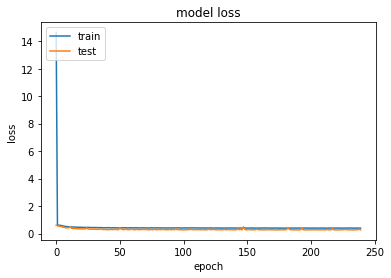

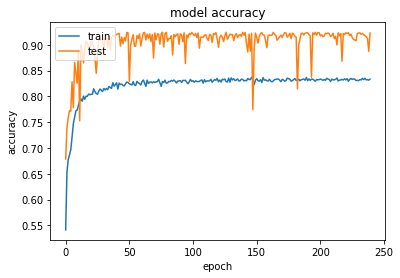

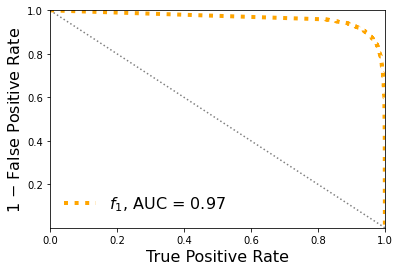

Classification score:


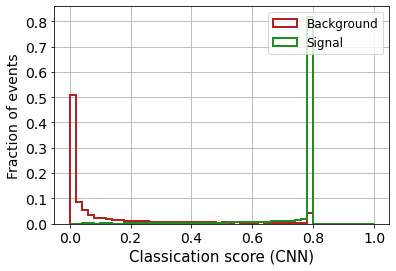


 ROC-AUC =  0.9654637312395353


In [68]:

# define the keras model
model = Sequential()
model.add(Conv1D(8, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Flatten())
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)